In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from inspect import ismethod
from datetime import timedelta as _time
from datetime import datetime
from collections.abc import Iterable as iterable

def some(field): return (field != None and field != [] and field != {} and field != ()) or field == True
def no(field): return not some(field) or field==False or field==''

class class_of:
    _instance = None
    def __init__(_, object):
        _._is = type(object)
    def inherits(_, *types):
        return issubclass(_._is, types)
    def has(_, *types): return _.inherits(*types)
    def __enter__(self):
        self._instance = self
        return self
    def __exit__(self, type, value, traceback): self._instance = None
    @staticmethod
    def each_in(list):
        if isiterable(list):
            return [type(item) for item in list]

class struct:
    def __init__(table, **sets): table.__dict__.update(sets)
    @property
    def sets(this): return set(dir(this)) - set(dir(type(this)))
    def set(object, **fields):
        for field in fields: setattr(object, field, fields[field])
    def get(object, *fields): return [getattr(object, field) for field in fields if field in object.__dict__]
    def _clonable(set, mask=None):
        check = set.__dict__.copy()
        clonable = check.copy()
        if some(mask): pass
#            for field in check:
#                if sum([int(_(check[field])) for _ in mask])+sum([int(_(field)) for _ in mask]): clonable.pop(field)
        return clonable
    @staticmethod
    def _from(type):
        if hasattr(type, '__dict__'): return struct(**type.__dict__.copy())
        return struct()

def meta(data, *mask): return struct._from(data)._clonable(mask)
def get(data, *fields):
    if not issubclass(type(data), dict): data=struct._from(data)._clonable()
    return struct(**data).get(*fields)

class table(struct):
    def _default(field, name, value):
        try: return getattr(field, name)
        except: setattr(field, name, value)
        return value
    def clear(this, *fields):
        sets = this.sets
        if not fields: fields = sets
        if fields:
            set = [field for field in fields if hasattr(this,field) and not ismethod(getattr(this, field))]
            for field in set: delattr(this, field)
    def has(this, *fields):
        return all([hasattr(this, field) for field in fields])
    def has_not(this, *fields): return not this.has(*fields)
    def check(this, **KV):
        try: check = [KV[key]==this.__dict__[key] for key in KV]
        except: return False
        return all(check)
    def find(this, _type):
        return [value for value in this.sets if class_of(get(this,value)[0]).inherits(_type)]
    def clone(this):
        clone = type(this)()
        sets = this._clonable()
        clone.set(**sets)
        return clone

def isiterable(this): return isinstance(this, iterable) and type(this) is not str
def default(field, name, value): return table(**field)._default(name, value)

def ni(list):
    if isiterable(list):
        for n,i in enumerate(list): yield n,i
    else:
        for n,i in enumerate(list.__dict__.keys()): yield n,i

class at(table):
    DAY, HOUR, MIN = 86400, 3600, 60
    def __init__(_, dtime=None, **sets):
        _.set(**sets)
        if some(dtime) and issubclass(type(dtime), _time): _._time = dtime
        else:
            d,h,m,s,ms = _._default('d',0), _._default('h',0), _._default('m',0), _._default('s',0), _._default('ms',0)
            if not any([d,h,m,s,ms]): now=datetime.now(); _._time = now-datetime(now.year, now.month, now.day)
            else: _._time = _time(days=d, hours=h, minutes=m, seconds=s, milliseconds=ms)
        _.clear('d','h','m','s','ms')
    def __sub__(_, dtime):
        of=type(dtime); sets=_._clonable()
        if issubclass(of, _time): return at(_._time-dtime, **sets)
        elif issubclass(of, at): sets.update(dtime._clonable()); return at(_._time-dtime._time, **sets)
    def __add__(_, dtime):
        of=type(dtime); sets=_._clonable()
        if issubclass(of, _time): return at(_._time+dtime, **sets)
        elif issubclass(of, at): sets.update(dtime._clonable()); return at(_._time+dtime._time, **sets)
    def __str__(_): return str(_._time)
    @property
    def seconds(_): return _._time.seconds
    @property
    def S(_): return _.seconds
    @property
    def minutes(_): return _._time.seconds/60
    @property
    def M(_): return _.minutes
    @property
    def hours(_): return _.minutes/60
    @property
    def H(_): return _.hours
    @property
    def days(_): return _._time.days
    @property
    def D(_): return _.days
    @staticmethod
    def zero(): return at(_time())

from inspect import isfunction, ismethod, isgeneratorfunction, isgenerator, isroutine
from inspect import isabstract, isclass, ismodule, istraceback, isframe, iscode, isbuiltin
from inspect import ismethoddescriptor, isdatadescriptor, isgetsetdescriptor, ismemberdescriptor
from inspect import isawaitable, iscoroutinefunction, iscoroutine

from collections.abc import Iterable as iterable

from pickle import load, dump

def isfx(field): return ismethod(field) or isfunction(field)

class GhostSet:
    """ enhanced interface (ghost) to retrieve class fields """
    def _meta(data): return {k:v for k,v in data.__dict__.items() if not isfx(v)}
    def _at_last(_, sets): pass
    def _set(object, **sets):
        ''' use to fast initialize fields | needed to avoid initialization problems at copy by value '''
        for field in sets: setattr(object, field, sets[field])
        object._at_last(sets)
GSet = GhostSet

def meta(object):
    ''' retrieves clonable object metadata (__dict__) as a copy '''
    if isinstance(object, GSet): return object._meta()
    return {}

class ClonableObjectGhost:
    """ enhanced interface (ghost) for clonable objects """
    def _by_val(_, depth=-1, _layer=0): pass
GCo = ClonableObjectGhost

class ClonableObject(GSet, GCo):
    """ base clonable object """
    def __init__(this, **data): this._set(**data)
    def __call__(_, **options): _._set(**options)
    def _by_val(_, depth=-1, _layer=0):
        copy = type(_)()
        copy._set(**_._meta())
        if depth<0 or depth>_layer:
            for field in copy.__dict__:
                if isinstance(copy.__dict__[field], ClonableObjectGhost):
                    copy.__dict__[field] = copy.__dict__[field]._by_val(depth,_layer+1)
        return copy
COb = ClonableObject

def copy_by_val(object, depth=-1, _layer=0):
    if isinstance(object, GCo): return object._by_val(depth,_layer)
    return object
copy = by_val = vof = copy_by_val

class ComparableGhost:
    """ enhanced interface (ghost) for comparing instances """
    def _compare(a, b):
        if type(a) != type(b): return False
        if a.__dict__ == b.__dict__: return True
        return False
    def __eq__(a, b): return a._compare(b)
GEq = ComparableGhost

class IterableObjectGhost(GSet):
    """ enhanced interface (ghost) for iterables: exposes __dict__,
        therefore Iterable Objects are like lua dictionaries """
    def __contains__(this, key): return key in this.__dict__
    def __iter__(this): return iter(this.__dict__)
    def items(my): return my.__dict__.items()
    def __getitem__(by, field): return by.__dict__[field]
    def __setitem__(by, field, value): by.__dict__[field] = value
    def pop(by, field): return by.__dict__.pop(field)
GIo = IterableObjectGhost

class ReprGhost:
    """ enhanced interface (ghost) for the skeleton method _repr,
        see implementation of Struct for a working example;
        Record __repr__ override uses _lines_ for max lines display """
    _lines_ = 31
    _chars_ = 13
    _msgsz_ = 62
    _ellipsis_ = ' ... '
    def _repr(my, value):
        _type = ''.join(''.join(str(type(value)).split('class ')).split("'"))
        _value = '{}'.format(value)
        if len(_value)>my._chars_:
            show = int(my._chars_/2)
            _value = _value[:show]+my._ellipsis_+_value[-show:]
        return '{} {}'.format(_type, _value)
    def _resize(this, message, at=.7):
        if len(message)>this._msgsz_:
            start = int(at*this._msgsz_)
            end = this._msgsz_-start
            return message[:start]+this._ellipsis_+message[-end:]
        return message
GRe = ReprGhost

def set_repr_to(lines): GRe._lines_ = lines

class Struct(COb, GEq, GIo, GRe):
    """ structured autoprintable object, behaves like a lua dictionary """
    def __repr__(_):
        return '\n'.join(['{}:\t{}'.format(k, _._repr(v)) for k,v in _.items()])
struct = Struct

class RecordableGhost:
    """ enhanced interface (ghost) for type recording,
        see Record for a working example """
    @staticmethod
    def load(filename):
        with open(filename, 'rb') as file: return load(file)
    def save(data, filename):
        with open(filename, 'wb') as file: dump(data, file)

GRec = RecordableGhost

class Record(GSet, GCo, GRec, GEq, GRe):
    """ wrapper for any object or value, auto-inspects and provides load/save type structure """
    data = None
    _check = dict(
            isfunction=isfunction, ismethod=ismethod, isgeneratorfunction=isgeneratorfunction, isgenerator=isgenerator, isroutine=isroutine,
            isabstract=isabstract, isclass=isclass, ismodule=ismodule, istraceback=istraceback, isframe=isframe, iscode=iscode, isbuiltin=isbuiltin,
            ismethoddescriptor=ismethoddescriptor, isdatadescriptor=isdatadescriptor, isgetsetdescriptor=isgetsetdescriptor, ismemberdescriptor=ismemberdescriptor,
            isawaitable=isawaitable, iscoroutinefunction=iscoroutinefunction, iscoroutine=iscoroutine
                   )
    def __init__(this, token, **meta):
        this.data = token
        this.__dict__.update({k:v(token) for k,v in this._check.items()})
        super()._set(**meta)
    @property
    def type(_): return type(_.data)
    def inherits(_, *types): return issubclass(_.type, types)
    @property
    def isbaseiterable(_): return _.inherits(tuple, list, dict, set) or _.isgenerator or _.isgeneratorfunction
    @property
    def isiterable(_): return isinstance(_.data, iterable) and _.type is not str
    def _clone_iterable(_):
        if _.inherits(dict): return _.data.copy()
        elif _.isgenerator or _.isgeneratorfunction: return (i for i in list(_.data))
        else: return type(_.data)(list(_.data)[:])
    def _meta(data): return {k:v for k,v in data.__dict__.items() if k != 'data' and not isfx(v)}
    def _by_val(_, depth=-1, layer=0):
        data = _.data
        if _.isiterable: data = _._clone_iterable()
        elif _.inherits(ClonableObjectGhost): data = by_val(data, depth, layer)
        return type(_)(data, **meta(_))
    def __enter__(self): self._instance = self; return self
    def __exit__(self, type, value, traceback): self._instance = None
    def __repr__(self):
        if not hasattr(self, '_preprint'): return Record(self.data, _preprint='', _lines=Record(Record._lines_)).__repr__()
        if self.isbaseiterable:
            pre, repr = self._preprint, ''
            for n,i in enumerate(self.data):
                if self._lines.data == 0: break
                else: self._lines.data -= 1
                index, item = str(n), i
                if self.inherits(dict): index += ' ({})'.format(str(i)); item = self.data[i]
                repr += pre+'{}: '.format(index)
                next = Record(item, _preprint=pre+'\t', _lines=self._lines)
                if next.isiterable: repr += '\n'
                repr += next.__repr__()
                repr += '\n'
            return repr
        elif self.inherits(GCo): return Record(self.data._meta(), _preprint=self._preprint, _lines=self._lines).__repr__()
        else: return self._repr(self.data)
REc = Record

class Bisect(list, COb):
    """ bisect implementation using clonable objects """
    def __init__(set, *items, key=None, reverse=False):
        if not key: key = lambda  x:x
        super().__init__(sorted(items, reverse=reverse, key=key))
    def _bisect(set, item, key, reverse, bottom, top):
        def _(check):
            if key: return key(check)
            return check
        at = int((top-bottom)/2)+bottom
        if len(set)==0: return (0,-1)
        if item==_(set[at]): return (at,0)
        bigger = item<_(set[at])
        if bigger != reverse:
            if at-bottom>0: return set._bisect(item, key, reverse, bottom, at)
            return (at,-1)
        elif top-at>1: return set._bisect(item, key, reverse, at, top)
        return (at,1)
    def search(_, item, key=None, reverse=False):
        if not key: key = lambda x:x
        return _._bisect(item, key, reverse, 0, len(_))
    def _by_val(_, depth=-1, _layer=0):
        copy = super()._by_val(depth, _layer)
        copy += _[:]
        return copy
BSx = Bisect

from numpy import ndarray, resize, linspace, arange
from numpy import min, max, average, floor
from numpy import ubyte, zeros, array
from scipy.signal import lfilter, butter
from matplotlib import pylab as lab

_NOTCH = _FR = 50
_SAMPLING = 500
_CONTINUOUS = 1
_UNIT = 'ms'

class rec(table, ndarray):
    @property
    def dimensions(of): return len(of.shape)
    @property
    def is_scalar(this): return this.shape is ()
    @property
    def is_vector(this): return len(this.shape)==1
    @property
    def is_matrix(this): return len(this.shape)>1
    @property
    def is_cube(this): return len(this.shape) == 3
    @property
    def is_binary(this): return this.dtype == ubyte and max(this) == 1
    @property
    def serialized(data):
        if not data.is_scalar and data.dimensions>1:
            return rec.read(data.T.flatten(), _deser=data.T.shape, **meta(data))
        return data
    @property
    def deserialized(data):
        if data.has('_deser'):
            deser = rec.read(resize(data, data._deser).T, **meta(data))
            deser.clear('_deser')
            return deser
        return data
    @property
    def as_matrix(data):    #implement numpy matrix
        if data.is_vector: return rec.read([data], to=type(data), **meta(data))
        return data
    @property
    def raw(data):
        if data.shape[0] == 1: return rec.read(data[0], **meta(data)).raw
        return data
    def join(base, *parts, **sets):
        flip, parts = None, list(parts)
        if 'flip' in sets: flip=sets.pop('flip')
        next = parts[0]
        if len(parts)>1: next = rec.join(parts[0], parts[1:])
        congruent = base.dimensions == next.dimensions and base.dimensions < 3
        if congruent:
            sets.update(base._clonable())
            A, B = base, next
            if flip: A, B = base.T, next.T
            C = record(A.tolist()+B.tolist(), **sets)
            if flip: return record(C.T, **sets)
            return C
    def get_as(this, data, cast=None):
        source = this
        if no(cast):
            if issubclass(type(data), rec): cast = type(data)
            else: cast = type(this)
        if issubclass(type(data), ndarray): source = resize(this, data.shape)
        return rec.read(source, to=cast, **meta(data))
    @staticmethod
    def read(iterable, to=None, **sets):
        if no(to) or not issubclass(to, rec): to = rec
        data = array(iterable).view(to)
        data.set(**sets)
        return data
    def clone(this, **sets):
        copy = this.copy().view(type(this))
        sets.update(this._clonable())
        copy.set(**sets)
        return copy
    def exclude(data, *items, **sets):
        if no(items) or data.is_scalar: return data
        excluded, items = None, [item for item in range(len(data)) if item not in items]
        if data.is_vector: excluded = rec.read([data])[:,items][0]
        else: excluded = data[items,:]
        return rec.read(excluded, to=type(data), **meta(data), **sets)
    def include(data, *items, **sets):
        if no(items) or data.is_scalar: return data
        included = []
        if data.is_vector: included = rec.read([data])[:,items][0]
        else: included = data[items,:]
        return rec.read(included, to=type(data), **meta(data), **sets)

create = record = rec.read
line = linspace

def series(ori,end=None,by=1):
    if no(end): end=ori; ori=0
    if not issubclass(type(by), int): return create(arange(ori,end,by))
    return array(range(ori,end,by))

def plot(data, at = 0., spacing = 1., color = 'k', width = 1., offset=0.): #review
    draw = record(data, **meta(data)); at = spacing*draw.as_matrix.shape[0]
    axes = lab.gca(); axes.set_ylim([at+max(data),0-max(data)]); at=0
    for n, row in ni(draw.as_matrix):
        if some(offset): row = draw[n]-average(row)+offset
        c, w = color, width
        if isiterable(color): c = color[n]
        if isiterable(width): w = width[n]
        lab.plot(at+row+n*spacing, color = c, linewidth = w)

def butter_type(lowcut, highcut, fs, order=5, type='band'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=type)
    return b, a

def butter_filter(data, lowcut, highcut, fs, order=5, type='band'):
    b, a = butter_type(lowcut, highcut, fs, order=order, type=type)
    y = lfilter(b, a, data)
    return y

def _to_rec(this):
    if not issubclass(type(this), rec): return rec.read(this, **meta(this)), rec
    return this, type(this)

def _prefilt(data, fs):
    pre = []
    for line in data.as_matrix:
        vector = line.tolist()
        pre.append(vector[:int(fs)]+vector)
    return record(pre)

def _postfilt(data, fs):
    post = []
    for line in data:
        vector = line.tolist()
        post.append(vector[int(fs):])
    return post

def notch(this, using=butter_type, fs=_SAMPLING, size=2, at=_NOTCH, order=5):
    data, type = _to_rec(this)
    if data.has('sampling'): fs=data.sampling
    nyq, cutoff = fs / 2., []
    for f in range(int(at), int(nyq), int(at)):
        cutoff.append((f - size, f + size))
    signal = _prefilt(data, fs)
    for bs in cutoff:
        low,hi = bs
        b,a = butter_type(low,hi,fs,order,'bandstop')
        signal = lfilter(b,a,signal)
    return record(_postfilt(signal, fs), to=type, **meta(data))

def band(this, low_high, fs=_SAMPLING, using=butter_filter, order=5):
    data, type = _to_rec(this)
    if data.has('sampling'): fs=data.sampling
    low, high = min(low_high), max(low_high)
    if low<1.: low = 1.
    tailed = _prefilt(data, fs)
    tailed = using(tailed, low, high, fs, order)
    return rec.read(_postfilt(tailed, fs), to=type, **meta(data))

def binarize(this):
    data, type = _to_rec(this)
    if data.is_binary: return data
    rows = []
    for row in data.as_matrix:
        d = row - array([row[-1]]+row[:-1].tolist())
        d[d>=0] = 1; d[d<0] = 0
        rows.append(d.astype(ubyte))
    return rec.read(rows, to=type).get_as(data)

def halve(matrix):
    halved, (data, type) = [], _to_rec(matrix)
    for line in data.as_matrix:
        h = resize(line, (int(len(line)/2), 2))
        halved.append((h[:,0]+h[:,1])/2.)
    return rec.read(halved, to=type, **meta(data))

def dwindle(matrix, by=1):
    if by: return dwindle(halve(matrix), by-1)
    return matrix

def upsample(matrix, fs1, fs2):
    y=zeros((matrix.shape[0],fs2))
    if fs1 < fs2:
        #upsampling by a factor R
        L=matrix.shape[1]
        R=int(floor(fs2/fs1)+1)
        for i,e in enumerate(matrix):
            ups=[]
            for j in range(L-1):
                if j>0: ups.append(list(linspace(matrix[i][j],matrix[i][j+1],R)[1:3]))
                else: ups.append(list(linspace(matrix[i][j],matrix[i][j+1],R)[0:3]))
            for k,s in enumerate(sum(ups, [])): y[i][k]=s
            y[i][-1]=y[i][-2]
        return rec.read(y)
    else: print("Error: fs1 >= fs2")

def remap(this, axis=None, base=0, top=1., e=0):
    def map(x, b, t, e): return ((x-min(x)+e)/(max(x)-min(x)+e)+b)*(t-b)
    data, type = _to_rec(this)
    if no(axis): return rec.read(map(this, base, top, e), to=type, **meta(data))
    rows = data.as_matrix
    if axis==0 or axis>1: rows = rows.T
    remapped = []
    for row in rows: remapped.append(map(row, base, top, e))
    if axis==0 or axis>1: rows = rows.T
    return rec.read(remapped).get_as(data)

this = Record

from numpy import median, random
import scipy.stats as stats

class Table(COb, GEq, GRe):
    data = None
    default = None
    PAD = 3
    ELLIPSIS_AT = int(GRe._lines_*.3)
    class _axes(list):
        def insert(_from, this, item):
            super().insert(this, item)
            _from.__dict__[item.name] = item
        def __setitem__(_, pos, axis):
            super().__setitem__(pos, axis)
            _.__dict__[axis.name] = axis
    class axis(list, GSet, GRe):
        name = None
        root = None
        _to = 0
        def __init__(axis, root, labels, name='ax', force_at=None):
            if force_at: root.axes[force_at].name = None
            with this(labels) as dim:
                if not dim.isiterable and dim.inherits(int): labels = range(labels)
            super().__init__(labels)
            names = [ax.name for ax in root.axes]
            name_, n = name, 1
            while name in names: name = name_ + str(n); n+=1
            axis._set(root=root, name=name)
            if force_at: root.axes[force_at] = axis
            else: root.axes.insert(0, axis)
        def at(axis, field):
            field = int(field) if this(field).inherits(str) and field.isdecimal() else field
            found = axis.index(field) if field in axis else None
            axis._to = found if found is not None else field
        def __repr__(_):
            return '{}: {}'.format(_.name, _._resize(' '.join([str(i) for i in _])))
    def __init__(this, **table_description):
        super().__init__(axes=this._axes())
        this.set(**table_description)
    def reset(data):
        base = None
        if len(data.axes)>0:
            base = [data.default]*len(data.axes[-1])
            for ax in reversed(data.axes[0:-1]): base = [base]*len(ax)
        data._set(data=array(base))
    @property
    def ax_names(_): return [ax.name for ax in _.axes]
    def at(data, axis):
        with this(axis) as _axis:
            if _axis.inherits(int):
                if axis>0 and axis<len(data.axes): return data.axes[axis]
            elif _axis.inherits(str):
                axes = data.ax_names
                if axis in axes: return data.axes[axes.index(axis)]
        return None
    def _check(build):
        if build.data is None: build.reset()
        return build.data
    def _find(_, inverted, ax_field):
        _._check()
        def index(axis, entry):
            fields = _.at(axis)
            if fields is not None:
                if this(entry).isiterable:
                    return tuple([fields.index(field) for field in entry])
                else: return ':'
            return None
        def translate(axis, found):
            if axis.name in found:
                _range = found[axis.name]
                if this(_range).inherits(tuple):
                    if inverted: found[axis.name] = tuple([field for field in range(len(axis)) if field not in _range])
                    return "_from['{}']".format(axis.name)
            return ':'
        found={field:index(field,entry) for field,entry in ax_field.items()}
        found={field:value for field,value in found.items() if value is not None}
        reshape='M['+','.join([translate(axis,found) for axis in _.axes])+']'
        _._set(_reshape_ = (reshape, found))
    def _by_val(_, depth=-1, _layer=0):
        M, axes = _._check(), _.axes
        do, _from = _.__dict__.pop('_reshape_') if '_reshape_' in _._meta() else (None, {})
        copy = super()._by_val(depth, _layer)
        copy.axes = []
        for ax in reversed(axes):
            fields = [field for n,field in enumerate(ax) if n in _from[ax.name]] if ax.name in _from else ax
            copy.set(**{ax.name:fields})
        copy.data = eval(do) if do else M.copy()
        return copy
    def _translate(_, directions):
        axes = directions.split(',')
        for ax_dir in axes:
            ax, field = [token.strip() for token in ax_dir.split(':')]
            axis = _.at(ax)
            if axis: axis.at(field)
        return '['+','.join([str(ax._to) for ax in _.axes])+']'
    def _get_set(_, directions, mode='get', value=None):
        if mode == 'get' and not '_MGET' in _.sets: _._MGET = []
        if len(directions) == len(_.axes):
            resolve, message = True, []
            for n,part in enumerate(directions):
                _part = this(part)
                if _part.inherits(int, str) or _part.isiterable and len(part)==1:
                    token = part if _part.inherits(str, int) else part[0]
                    message.append(':'.join([str(_.axes[n].name),str(part)]))
                else:
                    resolve = False
                    for token in part:
                        redirection = list(directions)
                        redirection[n] = token
                        _._get_set(tuple(redirection), mode, value)
            if resolve:
                message = ','.join(message)
                if mode=='get': _._MGET.append(_[message])
                else: _[message] = value
    def __getitem__(by, field_directions):
        M = by._check()
        if this(field_directions).inherits(tuple):
            by._get_set(field_directions)
            result = by.__dict__.pop('_MGET')
            return result
        else: return eval('M'+by._translate(field_directions))
    def __setitem__(by, field_directions, value):
        M = by._check()
        if this(field_directions).inherits(tuple): by._get_set(field_directions, 'set', value)
        else: exec('M'+by._translate(field_directions)+'=value')
    def set(data, **ax_field):
        for name, fields in ax_field.items(): data.axis(data, fields, name)
    def get(data, **ax_field):
        data._find(0, ax_field)
        return data._by_val()
    def let(data, **ax_field):
        data._find(1, ax_field)
        return data._by_val()
    @property
    def sets(tree): return set(meta(tree))
    def __repr__(self):
        M = self._check()
        _repr, dimensions = '', len(self.axes)
        if not dimensions: _repr += 'void table\n'
        else:
            dimensions = len(self.axes)
            y = self.axes[-2] if dimensions >= 2 else None
            if dimensions>2:
                y = self.axes[-2]
                for n,ax in enumerate(self.axes[:-2]): _repr += '{}{}: {}/{}\n'.format('\t'*n, ax.name, ax._to, len(ax))
            mr = eval('M'+str([ax.index(ax._to) for ax in self.axes][:-2])) if dimensions>2 else M
            pad = max([len(y.name)]+[len(str(field)) for field in y]+[len(str(value)) for line in mr for value in line])+self.PAD if dimensions>1 else 0
            _repr, x, spaces = _repr+y.name+'\n' if y else '', self.axes[-1], ' '*pad if pad>0 else '\t'
            header = spaces+''.join([str(field).ljust(pad) for field in x])
            _repr += self._resize(header) + '\n'
            ellipsis_at = self._lines_-self.ELLIPSIS_AT-1
            last_values_from = len(mr)-self.ELLIPSIS_AT
            if last_values_from<=ellipsis_at: last_values_from = ellipsis_at+1
            for n, line in enumerate(mr):
                if n<ellipsis_at or n>last_values_from:
                    values = str(y[n]).ljust(pad) if y else ''
                    values += ''.join([str(value).ljust(pad) for value in line])
                    _repr += self._resize(values) + '\n'
                elif n==ellipsis_at:
                    _repr += self._ellipsis_ + '\n'
        extra = {k:v for k,v in meta(self).items() if k != 'data' and k != 'axes'}
        _repr += self._resize(spaces*len(x)+x.name)+'\n'+'\n'.join(['{}:\t{}'.format(k, self._repr(v)) for k,v in extra.items()])
        return _repr
TAb = tab = Table

def set_repr_to(lines, ratio=.7):
    set_repr_to(lines)
    Table.ELLIPSIS_AT = int(Table._lines_*(1-ratio))

def butter_type(lowcut, highcut, fs, order=5, type='band'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=type)
    return b, a

def butter_filter(data, lowcut, highcut, fs, order=5, type='band'):
    b, a = butter_type(lowcut, highcut, fs, order=order, type=type)
    y = lfilter(b, a, data)
    return y

!pip install pyEDFlib # installing the pyEDFlib library in the Google Colab environment

import pyedflib as edf

class EEG(Table):
    LABEL_START = 'EEG '
    BAD = ['TTL', 'ECG']
    BP_SEP = '-'
    class time:
        """ converts time units to seconds by frequency sampling (fs) """
        unit = 'units'
        def __init__(_, units): _.time = units
        def __call__(_, fs=None): return _.time/fs
        def __repr__(_): return '{} {}'.format(str(_.time),_.unit)
    class ms(time):
        """ converts ms to time units by frequency sampling (fs) """
        unit = 'ms'
        def __call__(_, fs=1000): return int(round(_.time*fs/1000))
    class secs(time):
        """ converts seconds to time units by frequency sampling (fs) """
        unit = 's'
        def __call__(_, fs=1000): return int(_.time*fs)
    def _load(eeg, epoch, n):
        data = None
        with edf.EdfReader(eeg.file) as file:
            data = [file.readSignal(eeg.labels[id], epoch.at, epoch.span) for id in eeg.labels]
            file.close()
        if data is not None:
            eeg._set(data=array(data), at_epoch=(n, epoch()))
        else:
            if 'at_epoch' in eeg.sets: del(eeg.at_epoch)
            eeg._set(data=None)
    class step(GSet):
        START = 0
        CENTRE = 1
        END = 2
        def __init__(step, space, duration):
            step._set(at=space, span=duration)
        def reset(grid, at=0, root=None):
            if root: grid._set(root=root)
            else: root = grid.root
            all_space, left = root.duration(root.fs), 0
            if grid.at.time == 0: epochs = [EEG.step(0, all_space)]
            else:
                space, span, epochs = grid.at(root.fs), grid.span(root.fs), []
                for x in range(at, all_space, space):
                    end = x+span
                    if end>all_space: left = all_space-x
                    else: epochs.append(EEG.step(x, span))
            grid._set(_all=epochs, skip=at, out=left)
        def __call__(step, _as=None):
            if 'root' in meta(step):
                if _as == None: return len(step._all)
            elif _as is not None: step.id = _as
            elif 'id' in meta(step): return step.id
        def items(wrapped):
            if 'root' in meta(wrapped): return wrapped._all
        def __getitem__(by, epoch_n):
            if 'root' in meta(by) and epoch_n<len(by._all):
                by.root._load(by._all[epoch_n], epoch_n)
        def __repr__(_): return '|'.join([repr(_.at),repr(_.span)])
    class event(GSet):
        def __init__(event, to=None, group=None, _as=0, _from=0):
            event._set(mode=_from, note=group, id=_as)
            if to is not None: event.link(to)
        def link(event, to):
            if event.note is None or not 'event' in to.sets:
                if event.note is None:
                    to.event = event
                    event.type = []
                    return
                else: EEG.event(to)
            types = to.event.type
            ids = [to.event.id]+[_type.id for _type in types]
            while event.id in ids: event.id += 1
            if event.note in to.notes:
                event.at = to.notes[event.note]
                types.append(event)
        def __repr__(event):
            _repr = str(event.id)
            if 'at' in meta(event): _repr += ' at: {}'.format(event.at)
            if 'type' in meta(event):
                for subev in event.type: _repr += '; '+repr(subev)
            return _repr
    def _at_last(eeg, sets):
        if 'epoch' in meta(eeg):
            eeg.epoch.reset(root=eeg)
            if len(eeg.axes.time) != eeg.epoch.span(eeg.fs): eeg.axis(eeg, eeg.epoch.span(eeg.fs), 'time', 1)
    @staticmethod
    def from_file(name, step=None, bad=None):
        def correct_(label):
            if label.startswith(EEG.LABEL_START): return label[len(EEG.LABEL_START):]
            return label
        eeg = EEG()
        with edf.EdfReader(name) as file:
            if bad is None: bad = EEG.BAD
            duration = EEG.secs(file.getFileDuration())
            fs = file.getSampleFrequencies()[0]
            if step is None: step = EEG.step(EEG.secs(0), duration)
            raw_notes = file.readAnnotations()
            notes = {note:[] for note in set(raw_notes[-1])}
            for n, note in enumerate(raw_notes[-1]):
                notes[note].append(EEG.secs(raw_notes[0][n]))
            labels = [correct_(label) for label in file.getSignalLabels()]
            labels = {label:n for n,label in enumerate(labels) if label not in bad}
            eeg.set(time=step.span(fs), region=tuple(labels))
            eeg(file=name, duration=duration, fs=fs, notes=notes, labels=labels, epoch=step)
            file.close()
        return eeg
    def remap(eeg, at=None, step=None):
        sets = eeg.sets
        if this(step).inherits(EEG.step): eeg._set(epoch=step)
        if at is None:
            at = eeg._best_map if '_best_map' in sets else 0
        eeg.epoch.reset(at)
        if 'event' in sets:
            deltas = []
            for epoch in eeg.epoch._all: epoch.id = None
            for event in eeg.event.type:
                for time in event.at:
                    at, space, limit = time(eeg.fs), eeg.epoch.at(eeg.fs), len(eeg.epoch.items())-1
                    for n,epoch in enumerate(eeg.epoch.items()):
                        end = epoch.at+space if n<limit else epoch.span
                        if at>=epoch.at and at<end:
                            epoch(event.id)
                            if event.mode == eeg.step.START: deltas.append(EEG.time(at-epoch.at)(eeg.fs))
                            elif event.mode == eeg.step.END: deltas.append(EEG.time(end-at-1)(eeg.fs))
                            else:
                                centre = epoch.at+int(round(epoch.span/2))
                                deltas.append(EEG.time(abs(at-centre))(eeg.fs))
                            break
            for epoch in eeg.epoch._all:
                if epoch() is None: epoch(eeg.event.id)
            eeg.deltas = deltas
    def optimize(eeg, *events, grid=None):
        if events:
            for event in events: event.link(eeg)
        eeg.remap(0, grid)
        gaussian_space = stats.shapiro if len(eeg.deltas)<=5000 else stats.normaltest
        def test():
            _, p = gaussian_space(eeg.deltas) if len(eeg.deltas)>2 else 0,1
            if p<=0.05: return p, median(eeg.deltas)
            return p, average(eeg.deltas)
        (p, best), at, check = test(), 0, eeg.epoch.span(eeg.fs)
        print('optimizing epoch position...', end=' ')
        for _try in range(1, check):
            eeg.remap(_try)
            p, check = test()
            if check<best: p, best, at = p, check, _try
        _test = 'median' if p<0.05 else 'mean'
        print('best frame found at {:.3f}s with a {} delay of {:.3f}s'.format(EEG.time(at)(eeg.fs), _test, EEG.time(best)(eeg.fs)))
        eeg._set(_best_map=at)
    class sampler(GSet, GRe):
        eeg = None
        def __init__(map, root, *reserve, **opts):
            raw, proc = [step() for step in root.epoch.items()], []
            find, key = None, {k:v for k,v in reserve}
            for step in raw:
                if find==step: find=None
                if find is None: proc.append(step)
                else: proc.append(None)
                if step in key: find = key[step]
            key = {k:[] for k in list(set(raw))+[None]}
            for n,id in enumerate(proc): key[id].append(n)
            map._set(eeg=root, key=key, mask=proc, **opts)
        def _at_last(_, sets):
            if 'seed' in sets: random.seed(_.seed)
        def set(map, **event_range):
            prev, key = map.key, {}
            for k,deltas in event_range.items():
                if k in prev:
                    seq, key[k] = prev[k], []
                    for item in seq: key[k] += [item+d for d in deltas]
                    for o in prev:
                        if o != k:
                            for e in key[k]:
                                if e in prev[o]: prev[o].pop(prev[o].index(e))
            for k in prev:
                if k not in key: key[k] = prev[k]
            map._set(prev=prev, key=key)
        def get(map, event, times, random_seed=None):
            if random_seed and not 'seed' in meta(map): map._set(seed=random_seed)
            if not 'pool' in meta(map): map._set(pool = {k:map.key[k].copy() for k in map.key})
            resampled, sequence = [], []
            while times:
                if len(map.pool[event])==0: map.pool[event] = map.key[event].copy()
                at = map.pool[event].pop(random.randint(len(map.pool[event])))
                map.eeg.epoch[at]
                resampled.append(map.eeg.data)
                sequence.append(at)
                times -= 1
            return resampled, sequence
        def __repr__(_): return _._resize('|'.join([str(id) if id!=None else ' ' for id in _.mask]))
    def tag(event, *a_b, **event_range):
        event._set(sample=event.sampler(event, *a_b))
        event.sample.set(**event_range)

STEp = epoch = EEG.step
TIME = EEG.time
SET = EEG.event
secs = EEG.secs
ms = EEG.ms

def preprocess(eeg, epoch, limit=500):
    """Primary preprocessing. Resamples data to a limit frequency and applies a notch filter.

    Args:
        eeg (eeg): Wrapper object of the raw EEG data and metadata.
        epoch (list): Signal epoch.
        limit (int): Target frequency for resampling. Defaults to 500.

    Returns:
        list: Preprocessed epoch.
    """
    sampling, rse = limit, epoch
    if eeg.fs == limit: rse = epoch
    elif eeg.fs%limit != 0: rse = upsample(epoch, eeg.fs, limit) if eeg.fs<limit else dwindle(epoch, int(eeg.fs/limit)-1)
    else: rse = upsample(epoch, eeg.fs, limit) if eeg.fs<limit else dwindle(epoch, int(eeg.fs/limit)-2)
    nse = notch(rse, fs=sampling, order=2)
    return nse

<>:327: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:327: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-85a454968d1c>:327: SyntaxWarning: "is" with a literal. Did you mean "=="?
  def is_scalar(this): return this.shape is ()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.4 MB/s eta 0:00:00


In [3]:
main_folder = "/content/gdrive/My Drive/epigame-folder/30sec/"

cm_folder = main_folder + "connectivity_matrices/"
# cvs_folder = main_folder + "results/"

subject = 1
woi = "30sec"
measure = "PLI-(0,4)"

cm_filename = cm_folder + f"{subject}-{woi}-{measure}.prep"
# cvs_filename = cvs_folder + f"{subject}-{woi}-{measure}.res"

cm_load = REc.load(cm_filename)
# cvs_load = REc.load(cvs_filename)


In [4]:
cm = cm_load.data

In [20]:
n_epochs = int(len(cm.X)/2)

idx_cm_tuples = [(idx,cm.X[i]) for i,idx in enumerate(cm.i)]

idx_cm_1 = {idx:cm for (idx,cm) in idx_cm_tuples[:n_epochs]}
idx_cm_2 = {idx:cm for (idx,cm) in idx_cm_tuples[n_epochs::]}

idx_cm_1 = dict(sorted(idx_cm_1.items()))
idx_cm_2 = dict(sorted(idx_cm_2.items()))

In [6]:
def get_connectivity(matrix, row, col):
  # Get the connectivity measure for a node pair with indices row and col

    if row < 0 or row >= len(matrix) or col < 0 or col >= len(matrix[0]):
        return None  # Indices are out of bounds
    return matrix[row][col]

In [33]:
import numpy as np
import matplotlib.pyplot as plt

node1, node2 = 1,2

epochs_1 = list(idx_cm_1.values())
epochs_2 = list(idx_cm_2.values())
# List of connectivity measures for all epochs
conn_1 = [get_connectivity(cm, node1, node2) for cm in epochs_1]
conn_2 = [get_connectivity(cm, node1, node2) for cm in epochs_2]

print(np.mean(conn_1), np.mean(conn_2))

0.5541512605042018 0.553344537815126


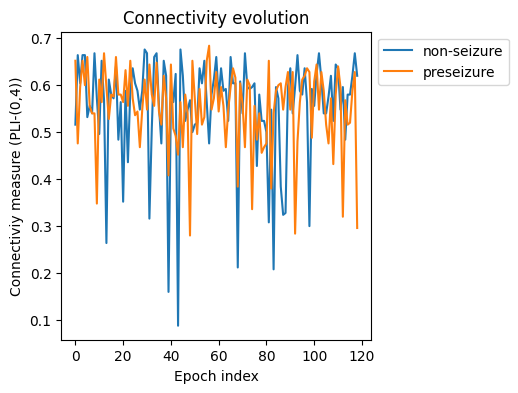

In [34]:
plt.figure(figsize=(4,4))
plt.plot(conn_1, label="non-seizure")
plt.plot(conn_2, label="preseizure")
plt.title("Connectivity evolution")
plt.xlabel("Epoch index")
plt.ylabel(f"Connectiviy measure ({measure})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [37]:
from scipy.stats import entropy

# Calculate Shannon entropy
# Shannon entropy measures the uncertainty or randomness in a time series. Higher entropy could indicate higher dynamics or volatility.
entropy_1 = entropy(conn_1, base=2)  # Set base to 2 for log base 2
entropy_2 = entropy(conn_2, base=2)  # Set base to 2 for log base 2

print(f"Shannon Entropy of non-seizure: {entropy_1:.4f}")
print(f"Shannon Entropy of preseizure: {entropy_2:.4f}")

Shannon Entropy of non-seizure: 6.8591
Shannon Entropy of preseizure: 6.8769


In [48]:
NODES = {
"1":['P1-P2', 'P4-P5', 'P8-P9', 'P9-P10', 'P10-P11', 'G1-G2', 'G8-G9', 'G9-G10', 'G10-G11', 'G11-G12', 'M1-M2', 'M8-M9', 'M9-M10', 'M10-M11', 'M11-M12', 'O1-O2', 'O2-O3', 'O5-O6', 'O6-O7', 'F1-F2', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'F12-F13', 'A1-A2', 'A2-A3', 'A3-A4', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B2-B3', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'C1-C2', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q8-Q9', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'L1-L2', 'L2-L3', 'L5-L6', 'L6-L7', 'L7-L8', 'U1-U2', 'U2-U3', 'U3-U4', 'U4-U5', 'U5-U6', 'U6-U7', 'J1-J2', 'J9-J10', 'J10-J11', 'J11-J12', 'J12-J13', 'J13-J14', 'J14-J15'],
"2":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8'],
"3":["T'1-T'2", "T'2-T'3", "T'3-T'4", "T'4-T'5", "T'5-T'6", "T'6-T'7", "T'7-T'8", "A'1-A'2", "A'2-A'3", "A'3-A'4", "A'4-A'5", "A'5-A'6", "A'6-A'7", "A'7-A'8", "A'8-A'9", "A'9-A'10", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'4-B'5", "B'5-B'6", "B'6-B'7", "B'7-B'8", "B'8-B'9", "B'9-B'10", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "C'11-C'12", "E'1-E'2", "E'2-E'3", "E'3-E'4", "E'4-E'5", "E'5-E'6", "E'6-E'7", "E'7-E'8", "E'8-E'9", "E'9-E'10", "D'1-D'2", "D'2-D'3", "D'3-D'4", "D'4-D'5", "D'5-D'6", "D'6-D'7", "D'7-D'8", "D'8-D'9", "D'9-D'10", "D'10-D'11", "D'11-D'12", "W'1-W'2", "W'2-W'3", "W'3-W'4", "W'4-W'5", "W'5-W'6", "W'6-W'7", "W'7-W'8", "W'8-W'9", "W'9-W'10", "W'10-W'11", "W'11-W'12", "W'12-W'13", "W'13-W'14", "W'14-W'15", "K'1-K'2", "K'2-K'3", "K'3-K'4", "K'4-K'5", "K'5-K'6", "K'6-K'7", "K'7-K'8", "K'8-K'9", "K'9-K'10", "K'10-K'11", "K'11-K'12", "K'12-K'13", "K'13-K'14", "K'14-K'15", "P'1-P'2", "P'2-P'3", "P'3-P'4", "P'4-P'5", "P'5-P'6", "P'6-P'7", "P'7-P'8", "P'8-P'9", "P'9-P'10", "P'10-P'11", "P'11-P'12", "P'12-P'13", "P'13-P'14", "P'14-P'15", "L'1-L'2", "L'2-L'3", "L'3-L'4", "L'4-L'5", "L'5-L'6", "L'6-L'7", "L'7-L'8", "L'8-L'9", "L'9-L'10", "L'10-L'11", "L'11-L'12", "O'1-O'2", "O'2-O'3", "O'3-O'4", "O'4-O'5", "O'5-O'6", "O'6-O'7", "O'7-O'8", "O'8-O'9", "O'9-O'10", "O'10-O'11", "O'11-O'12", "X'1-X'2", "X'2-X'3", "X'3-X'4", "X'4-X'5", "X'5-X'6", "X'6-X'7", "X'7-X'8", "X'8-X'9", "X'9-X'10", "X'10-X'11", "X'11-X'12", "X'12-X'13", "X'13-X'14", "X'14-X'15"],
"4":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B11-B12', 'C1-C2', 'C2-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'R1-R2', 'R2-R3', 'R3-R4', 'R4-R5', 'R5-R6', 'R6-R7', 'R7-R8', 'R8-R9', 'R9-R10', 'R10-R11', 'R11-R12', 'R12-R13', 'L1-L2', 'L2-L3', 'L3-L4', 'L4-L5', 'L5-L6', 'L6-L7', 'L7-L8', 'L8-L9', 'L9-L10', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q5-Q6', 'Q6-Q7', 'Q7-Q8', 'Q8-Q9', 'Q9-Q10', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'J1-J2', 'J2-J3', 'J6-J7', 'J7-J8', 'J8-J9', 'J9-J10', 'J10-J11', 'J11-J12', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'P4-P5', 'P5-P6', 'P6-P7', 'P7-P8', 'P8-P9', 'P9-P10'],
"5":["A'1-A'2", "A'2-A'3", "A'3-A'4", "A'4-A'5", "A'5-A'6", "A'6-A'7", "A'7-A'8", "A'8-A'9", "A'9-A'10", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'4-B'5", "B'5-B'6", "B'6-B'7", "B'7-B'8", "B'8-B'9", "B'9-B'10", "B'10-B'11", "B'11-B'12", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "C'11-C'12", "D'1-D'2", "D'2-D'3", "D'3-D'4", "D'4-D'5", "D'5-D'6", "D'6-D'7", "D'7-D'8", "F'1-F'2", "F'2-F'3", "F'3-F'4", "F'4-F'5", "F'5-F'6", "F'6-F'7", "F'7-F'8", "H'1-H'2", "H'2-H'3", "H'3-H'4", "H'4-H'5", "G'1-G'2", "G'2-G'3", "G'3-G'4", "G'4-G'5", "G'5-G'6", "G'6-G'7", "G'7-G'8", "G'8-G'9", "G'9-G'10", "G'10-G'11", "G'11-G'12"],
"6":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'D10-D11', 'D11-D12', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'E11-E12', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'H8-H9', 'H9-H10', 'H10-H11', 'H11-H12', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'I8-I9', 'I9-I10', 'I10-I11', 'I11-I12', "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10"],
"7":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "C'11-C'12", 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'G5-G6', 'G6-G7', 'G7-G8', 'G8-G9', 'G9-G10', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'I8-I9', 'I9-I10', 'I10-I11', 'I11-I12', 'J1-J2', 'J2-J3', 'J3-J4', 'J4-J5', 'J5-J6', 'J6-J7', 'J7-J8'],
"8":["F'1-F'2", "F'2-F'3", "F'8-F'9", "F'9-F'10", "F'10-F'11", "F'11-F'12", "T'1-T'2", "T'2-T'3", "T'3-T'4", "T'4-T'5", "T'5-T'6", "T'6-T'7", "T'7-T'8", "T'8-T'9", "T'9-T'10", "A'1-A'2", "A'2-A'3", "A'3-A'4", "A'4-A'5", "A'5-A'6", "A'6-A'7", "A'7-A'8", "A'8-A'9", "A'9-A'10", "A'10-A'11", "A'11-A'12", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'4-B'5", "B'8-B'9", "B'9-B'10", "B'10-B'11", "B'11-B'12", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "D'1-D'2", "D'2-D'3", "D'3-D'4", "D'4-D'5", "D'5-D'6", "D'6-D'7", "D'7-D'8", "D'8-D'9", "D'9-D'10", "S'1-S'2", "S'2-S'3", "S'5-S'6", "S'6-S'7", "S'7-S'8", "S'8-S'9", "S'9-S'10", "S'10-S'11", "S'11-S'12", "S'12-S'13", "S'13-S'14", "I'1-I'2", "I'2-I'3", "I'3-I'4", "I'4-I'5", "I'5-I'6", "I'6-I'7", "I'7-I'8", "I'8-I'9", "I'9-I'10", "W'1-W'2", "W'2-W'3", "W'10-W'11", "W'11-W'12", "W'12-W'13", "W'13-W'14", "W'14-W'15", "W'15-W'16", "W'16-W'17", "W'17-W'18", "U'1-U'2", "U'2-U'3", "U'3-U'4", "U'4-U'5", "U'8-U'9", "U'9-U'10", "U'10-U'11", "U'11-U'12", "U'12-U'13", "U'13-U'14", "U'14-U'15", "O'1-O'2", "O'2-O'3", "O'3-O'4", "O'4-O'5", "O'5-O'6", "O'6-O'7", "O'7-O'8", "O'8-O'9", "O'9-O'10", "O'10-O'11", "O'11-O'12", "O'12-O'13", "O'13-O'14", "O'14-O'15"],
"9":['FC1-FC2', 'FC2-FC3', 'FC3-FC4', 'FC4-FC5', 'FC5-FC6', 'FC6-FC7', 'FC7-FC8', 'FC8-FC9', 'FC9-FC10', 'A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'A8-A9', 'A9-A10', 'HAn1-HAn2', 'HAn2-HAnt3', 'HAnt3-HAnt4', 'HAnt4-HAnt5', 'HAnt5-HAnt6', 'HAnt6-HAnt7', 'HAnt7-HAnt8', 'HAnt8-HAnt9', 'HAnt9-HAnt10', 'HAnt10-Ref', 'HAnt11-Ref', 'HP1-HP2', 'HP2-HP3', 'HP3-HP4', 'HP4-HP5', 'HP5-HP6', 'HP6-HP7', 'HP7-HP8', 'HP8-HP9', 'HP9-HP10', 'TB1-TB2', 'TB2-TB3', 'TB3-TB4', 'TB4-TB5', 'TB5-TB6', 'TB6-TB7', 'TB7-TB8', 'TB8-TB9', 'TB9-TB10', 'TB10-TB11', 'TB11-TB12'],
"10":['F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'F12-F13', 'F13-F14', 'F14-F15', 'F15-F16', 'F16-F17', 'A1-A3', 'A3-A5', 'A5-A7', 'A7-A9', 'A9-A11', 'A11-A13', 'A13-A15', 'B1-B3', 'B3-B5', 'B5-B7', 'B7-B9', 'C1-C3', 'C3-C5', 'C5-C7', 'C7-C9', 'C9-C11', 'D1-D3', 'D3-D5', 'D5-D7', 'D7-D9', 'D9-D11', 'D11-D13', 'D13-D15', 'E1-E3', 'E3-E5', 'E5-E7', 'E7-E9', 'E9-E11', 'J1-J3', 'J3-J5', 'J5-J7', 'J7-J9', 'J9-J11', 'J11-J13', 'J13-J15', 'J15-J17', 'K1-K3', 'K3-K5', 'K5-K7', 'K7-K9', 'K9-K11', 'K11-K13', 'K13-K15', 'L1-L3', 'L3-L5', 'L5-L7', 'L7-L9', 'L9-L11', 'L11-L13', 'L13-L15', 'M1-M3', 'M3-M5', 'M5-M7', 'M7-M9', 'O1-O3', 'O3-O5', 'O5-O7', 'P1-P3', 'P3-P5', 'P5-P7', 'P7-P9', 'R1-R3', 'R3-R5', 'R5-R7', 'R7-R9', 'R9-R11', 'R11-R13', 'R13-R15', 'S1-S3', 'S3-S5', 'S5-S7', 'S7-S9', 'S9-S11', 'S11-S13', 'S13-S15', 'T1-T3', 'T3-T5', 'T5-T9', 'T9-T11'],
"11":["R'1-R'2", "R'2-R'3", "R'9-R'10", "R'10-R'11", "R'11-R'12", "R'12-R'13", "R'13-R'14", "S'1-S'2", "S'2-S'3", "S'6-S'7", "P'1-P'2", "P'2-P'3", "P'3-P'4", "P'4-P'5", "P'7-P'8", "P'8-P'9", "M'1-M'2", "M'8-M'9", "M'9-M'10", "M'10-M'11", "M'13-M'14", "J'1-J'2", "J'7-J'8", "J'8-J'9", "J'9-J'10", "K'1-K'2", "K'2-K'3", "K'7-K'8", "K'8-K'9", "K'9-K'10", "L'2-L'3", "L'3-L'4", "L'4-L'5", "L'5-L'6", "B'1-B'2", "B'5-B'6", "B'6-B'7", "B'7-B'8", "B'8-B'9", "C'1-C'2", "C'2-C'3", "C'9-C'10", "C'10-C'11", "C'11-C'12", "O'4-O'5", "O'5-O'6", "O'6-O'7", "O'10-O'11", "O'11-O'12", "O'12-O'13", "Q'3-Q'4", "Q'4-Q'5", "Q'5-Q'6", "Q'6-Q'7", "Q'10-Q'11", "Q'11-Q'12", 'S1-S2', 'S8-S9', 'S9-S10', 'S10-S11', 'P1-P2', 'P2-P3', 'P6-P7', 'P7-P8', 'K2-K3', 'K3-K4', 'K4-K5', 'L1-L2', 'L2-L3', 'L3-L4', 'L7-L8', 'J1-J2', 'J11-J12', 'J12-J13', 'J13-J14', 'C1-C2', 'C2-C3', 'C8-C9', 'C9-C10', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q12-Q13', 'Q13-Q14', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O9-O10'],
"12":["E'1-E'2", "E'2-E'3", "E'3-E'4", "E'4-E'5", "E'5-E'6", "E'6-E'7", "E'7-E'8", "E'10-E'11", "O'1-O'2", "O'2-O'3", "O'3-O'4", "O'4-O'5", "O'5-O'6", "O'6-O'7", "O'7-O'8", "O'8-O'9", "O'9-O'10", "O'10-O'11", "C'1-C'2", "C'2-C'3", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "T'1-T'2", "T'2-T'3", "T'8-T'9", "T'9-T'10", "T'10-T'11", "U'1-U'2", "U'4-U'5", "U'5-U'6", "U'8-U'9", "Q'1-Q'2", "Q'10-Q'11", "Q'11-Q'12", "Q'12-Q'13", "Q'13-Q'14", "Q'14-Q'15", "W'1-W'2", "W'6-W'7", "W'7-W'8", "W'8-W'9", "W'12-W'13", "W'13-W'14", "S'1-S'2", "S'8-S'9", "S'9-S'10", "S'10-S'11", "S'11-S'12", "P'1-P'2", "P'2-P'3", "P'3-P'4", "P'4-P'5", "P'5-P'6", "P'6-P'7", "P'7-P'8", "P'8-P'9", 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T11-T12', 'O1-O2', 'O2-O3', 'O5-O6', 'O6-O7', 'O7-O8', 'O8-O9', 'O9-O10', 'O10-O11', 'U1-U2', 'U5-U6', 'U6-U7', 'W1-W2', 'W2-W3', 'W3-W4', 'W9-W10', 'W10-W11', 'W11-W12', 'W12-W13', 'Q1-Q2', 'Q2-Q3', 'Q6-Q7', 'Q7-Q8', 'Q13-Q14', 'Q14-Q15', 'P1-P2', 'P4-P5', 'P5-P6', 'P6-P7', 'P10-P11'],
"13":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'A11-A12', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'B12-B13', 'B13-B14', 'B14-B15', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'G5-G6', 'G6-G7', 'G7-G8', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'H8-H9', 'H9-H10', 'H10-H11', 'H11-H12', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'I8-I9', 'I9-I10', 'L1-L2', 'L2-L3', 'L3-L4', 'L4-L5', 'L5-L6', 'L6-L7', 'L7-L8'],
"14":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'D10-D11', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', "G'1-G'2", "G'2-G'3", "G'3-G'4", "G'4-G'5", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10"],
"15":["A'1-A'2", "A'2-A'3", "A'6-A'7", "A'7-A'8", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'4-B'5", "B'5-B'6", "B'6-B'7", "B'7-B'8", "C'1-C'2", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "E'1-E'2", "E'2-E'3", "E'5-E'6", "E'6-E'7", "E'7-E'8", "E'8-E'9", "T'1-T'2", "T'2-T'3", "T'3-T'4", "T'8-T'9", "T'9-T'10", "T'10-T'11", "T'11-T'12", "T'12-T'13", "T'13-T'14", "T'14-T'15", "J'1-J'2", "J'2-J'3", "J'3-J'4", "J'4-J'5", "J'12-J'13", "J'13-J'14", "J'14-J'15", "I'1-I'2", "I'2-I'3", "I'3-I'4", "I'8-I'9", "I'9-I'10", "I'10-I'11", "O'1-O'2", "O'6-O'7", "O'7-O'8", "O'8-O'9", "O'9-O'10", "O'10-O'11", "G'1-G'2", "G'2-G'3", "G'10-G'11", "G'11-G'12", "G'12-G'13", "G'13-G'14", "G'14-G'15", "Q'1-Q'2", "Q'6-Q'7", "Q'7-Q'8", "Q'8-Q'9", "Q'11-Q'12", "Q'12-Q'13", "P'1-P'2", "P'2-P'3", "P'3-P'4", "P'4-P'5", "P'5-P'6", "P'6-P'7", "P'7-P'8", "P'8-P'9", "P'9-P'10", "U'1-U'2", "U'5-U'6", "U'6-U'7", "U'7-U'8", "U'8-U'9", "M'1-M'2", "M'2-M'3", "M'3-M'4", "M'4-M'5", "M'7-M'8", "M'8-M'9", "M'9-M'10", "M'10-M'11", "M'11-M'12", 'F1-F2', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'M1-M2', 'M2-M3', 'M3-M4', 'M12-M13', 'M13-M14'],
"16":["F'1-F'2", "F'5-F'6", "F'8-F'9", "F'9-F'10", "M'1-M'2", "M'8-M'9", "M'9-M'10", "M'10-M'11", "M'11-M'12", "M'12-M'13", "M'13-M'14", "O'4-O'5", "O'5-O'6", "O'6-O'7", "Y'1-Y'2", "Y'2-Y'3", "Y'3-Y'4", "Y'4-Y'5", "Y'5-Y'6", "Y'6-Y'7", "Y'13-Y'14", "Y'14-Y'15", "Y'15-Y'16", "Y'16-Y'17", "I'1-I'2", "I'5-I'6", "I'6-I'7", "I'7-I'8", "U'1-U'2", "U'2-U'3", "U'3-U'4", "U'4-U'5", "U'5-U'6", "A'1-A'2", "A'7-A'8", "A'8-A'9", "A'9-A'10", "A'10-A'11", "B'1-B'2", "B'2-B'3", "B'8-B'9", "B'9-B'10", "B'10-B'11", "C'1-C'2", "C'2-C'3", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'10-C'11", "C'11-C'12", "D'1-D'2", "D'6-D'7", "D'7-D'8", "D'8-D'9", "E'2-E'3", "E'3-E'4", "E'4-E'5", "E'5-E'6", "E'6-E'7", "E'7-E'8", "E'8-E'9", "E'9-E'10", "E'10-E'11", "J'1-J'2", "J'8-J'9", "J'9-J'10", "J'10-J'11", "J'11-J'12", "J'12-J'13", "J'13-J'14", "J'14-J'15", "W'1-W'2", "W'11-W'12", "W'12-W'13", "W'13-W'14", "Q'1-Q'2", "Q'2-Q'3", "Q'6-Q'7", "Q'7-Q'8", "Q'8-Q'9", "Q'9-Q'10", "Q'10-Q'11", 'A1-A2', 'A2-A3', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B7-B8', 'B8-B9', 'C1-C2', 'C7-C8', 'C8-C9'],
"17":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'D10-D11', 'D11-D12', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'G5-G6', 'G6-G7', 'G7-G8', 'G8-G9', 'G9-G10', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'H8-H9', 'H9-H10', 'J1-J2', 'J2-J3', 'J3-J4', 'J4-J5', 'J5-J6', 'J6-J7', 'J7-J8', 'J8-J9', 'J9-J10', 'J10-J11', 'J11-J12', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'O8-O9', 'O9-O10', 'O10-O11', 'O11-O12', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'I8-I9', 'I9-I10', 'I10-I11', 'I11-I12', 'I12-I13', 'I13-I14', 'I14-I15', 'I15-I16', 'I16-I17', 'I17-I18'],
"18":['F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'S1-S2', 'S2-S3', 'S3-S4', 'S4-S5', 'S5-S6', 'S6-S7', 'S7-S8', 'S8-S9', 'S9-S10', 'S10-S11', 'S11-S12', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'M1-M2', 'M2-M3', 'M3-M4', 'M4-M5', 'M5-M6', 'M6-M7', 'M7-M8', 'U1-U2', 'U2-U3', 'U3-U4', 'U4-U5', 'U5-U6', 'U6-U7', 'U7-U8', 'A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'A11-A12', 'A12-A13', 'A13-A14', 'A14-A15', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'J1-J2', 'J2-J3', 'J3-J4', 'J4-J5', 'J5-J6', 'J6-J7', 'J7-J8', 'J8-J9', 'J9-J10', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'O8-O9', 'O9-O10', 'O10-O11', 'O11-O12', 'O12-O13', 'O13-O14', 'O14-O15', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'L1-L2', 'L2-L3', 'L3-L4', 'L4-L5', 'L5-L6', 'L6-L7', 'L7-L8', 'L8-L9', 'L9-L10', 'P1-P2', 'P2-P3', 'P3-P4', 'P4-P5', 'P5-P6', 'P6-P7', 'P7-P8', 'P8-P9', 'P9-P10', 'P10-P11', 'P11-P12', 'P12-P13', 'P13-P14', 'P14-P15', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q5-Q6', 'Q6-Q7', 'Q7-Q8', 'Q8-Q9', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'Q12-Q13', 'Q13-Q14', 'Q14-Q15', 'X1-X2', 'X2-X3', 'X3-X4', 'X4-X5', 'X5-X6', 'X6-X7', 'X7-X8', 'X8-X9', 'X9-X10', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'Y1-Y2', 'Y2-Y3', 'Y3-Y4', 'Y4-Y5', 'Y5-Y6', 'Y6-Y7', 'Y7-Y8', 'Z1-Z2', 'Z2-Z3', 'Z3-Z4', 'Z4-Z5', 'Z5-Z6', 'Z6-Z7', 'Z7-Z8', 'Au1-Ref Au', 'Au2-Ref Au'],
"19":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'E11-E12', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5'],
"20":['A1-A2', 'A2-A3', 'A6-A7', 'A7-A8', 'A8-A9', 'A10-A11', 'A11-A12', 'B1-B2', 'B2-B3', 'B3-B4', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'D10-D11', 'D11-D12', 'J1-J2', 'J2-J3', 'J3-J4', 'J8-J9', 'J9-J10', 'J10-J11', 'J11-J12', 'J12-J13', 'J13-J14', 'J14-J15', 'K1-K2', 'K2-K3', 'K3-K4', 'K4-K5', 'K5-K6', 'K6-K7', 'K7-K8', 'K8-K9', 'K9-K10', 'K10-K11', 'K11-K12', 'K12-K13', 'K13-K14', 'P1-P2', 'P2-P3', 'P3-P4', 'P4-P5', 'P5-P6', 'P6-P7', 'P7-P8', 'P8-P9', 'P9-P10', 'P10-P11', 'P11-P12', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F9-F10', 'F10-F11', 'F11-F12', "A'1-A'2", "A'2-A'3", "A'3-A'4", "A'4-A'5", "A'8-A'9", "A'9-A'10", "A'10-A'11", "A'11-A'12", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'7-B'8", "B'8-B'9", "B'9-B'10", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10"],
"21":['X1-X2', 'X2-X3', 'X3-X4', 'X4-X5', 'X5-X6', 'X6-X7', 'X7-X8', 'X10-X11', 'X11-X12', 'X12-X13', 'X13-X14', 'X14-X15', 'X15-X16', 'X16-X17', 'X17-X18', 'I1-I2', 'I4-I5', 'I5-I6', 'I8-I9', 'I9-I10', 'A1-A2', 'A2-A3', 'A3-A4', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'T1-T2', 'T2-T3', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E6-E7', 'E7-E8', 'E8-E9', 'B1-B2', 'B2-B3', 'B3-B4', 'B8-B9', 'B9-B10', 'B10-B11', 'C1-C2', 'C2-C3', 'C3-C4', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D8-D9', 'D9-D10', 'D10-D11', 'S1-S2', 'S2-S3', 'S3-S4', 'S4-S5', 'S12-S13', 'S13-S14', 'S14-S15', 'S15-S16', 'S16-S17', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'Q12-Q13', 'Q13-Q14', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'O8-O9', 'O9-O10', 'O10-O11', 'O11-O12', 'P1-P2', 'P2-P3', 'P3-P4', 'P4-P5', 'P5-P6', 'P11-P12', 'P12-P13', 'P13-P14', 'P14-P15']
}

RESECTION = {1: ['T9-T10', 'T4-T5', 'B6-B7', 'B2-B3', 'D4-D5', 'D2-D3', 'T6-T7', 'B1-B2', 'T10-T11', 'T11-T12', 'T3-T4', 'T8-T9', 'T7-T8', 'A3-A4', 'T1-T2', 'T5-T6', 'T2-T3', 'B5-B6', 'D3-D4'], 2: ['A1-A2', 'B2-B3', 'B6-B7', 'A2-A3', 'B1-B2', 'C2-C3', 'C7-C8', 'B8-B9', 'B4-B5', 'C9-C10', 'A3-A4', 'C3-C4', 'B7-B8', 'C1-C2', 'C5-C6', 'C8-C9', 'A4-A5', 'C6-C7', 'C4-C5', 'B5-B6', 'B9-B10', 'B3-B4'], 3: ["D'8-D'9", "D'11-D'12", "W'14-W'15", "P'12-P'13", "L'9-L'10", "L'11-L'12", "O'9-O'10", "O'10-O'11", "K'13-K'14", "O'11-O'12", "D'6-D'7", "L'10-L'11", "P'13-P'14", "D'9-D'10", "W'13-W'14", "P'14-P'15", "K'12-K'13", "D'7-D'8"], 4: ['A10-A11', 'P7-P8', 'P9-P10', 'O4-O5', 'Q8-Q9', 'E2-E3', 'E9-E10', 'P6-P7', 'L1-L2', 'E4-E5', 'L4-L5', 'Q7-Q8', 'J7-J8', 'C9-C10', 'J8-J9', 'O6-O7', 'P8-P9', 'C11-C12', 'E3-E4', 'I6-I7', 'J9-J10', 'B11-B12', 'L2-L3', 'O5-O6', 'O3-O4', 'J10-J11', 'Q3-Q4', 'C10-C11', 'E10-E11', 'P5-P6', 'J6-J7', 'J11-J12', 'J1-J2', 'Q4-Q5', 'I7-I8', 'A9-A10', 'L3-L4', 'Q9-Q10'], 5: ["D'4-D'5", "D'2-D'3", "D'3-D'4", "D'1-D'2", "B'1-B'2", "D'6-D'7", "D'5-D'6", "D'7-D'8"], 6: ['C1-C2', 'C4-C5', 'C2-C3', 'C3-C4'], 7: ['F11-F12', 'G5-G6', 'E1-E2', 'F8-F9', 'A1-A2', 'B2-B3', 'B6-B7', 'A2-A3', 'D4-D5', 'D2-D3', 'E2-E3', 'E9-E10', 'G7-G8', 'C2-C3', 'G9-G10', 'G2-G3', 'E4-E5', 'G6-G7', 'A5-A6', 'D1-D2', 'G8-G9', 'C7-C8', 'E8-E9', 'I8-I9', 'B8-B9', 'B4-B5', 'F7-F8', 'F9-F10', 'H7-H8', 'J7-J8', 'A7-A8', 'C9-C10', 'D5-D6', 'H4-H5', 'H5-H6', 'D7-D8', 'B10-B11', 'A3-A4', 'E6-E7', 'G1-G2', 'E3-E4', 'A6-A7', 'B7-B8', 'C1-C2', 'C3-C4', 'C5-C6', 'F10-F11', 'G3-G4', 'H2-H3', 'H3-H4', 'B11-B12', 'E5-E6', 'D6-D7', 'C8-C9', 'I11-I12', 'J6-J7', 'F6-F7', 'A4-A5', 'C6-C7', 'C4-C5', 'E7-E8', 'G4-G5', 'I7-I8', 'B5-B6', 'D3-D4', 'B9-B10', 'I9-I10', 'I10-I11', 'B3-B4', 'H6-H7'], 8: ["T'7-T'8", "D'2-D'3", "A'3-A'4", "T'6-T'7", "A'6-A'7", "D'4-D'5", "A'7-A'8", "T'2-T'3", "A'1-A'2", "A'5-A'6", "A'8-A'9", "D'5-D'6", "A'2-A'3", "D'8-D'9", "A'4-A'5", "T'5-T'6", "D'3-D'4", "T'4-T'5", "D'7-D'8", "T'1-T'2", "T'3-T'4", "D'1-D'2"], 9: ['A3-A4', 'TB5-TB6', 'A8-A9', 'TB4-TB5', 'A4-A5', 'A6-A7', 'TB6-TB7', 'A1-A2', 'A2-A3', 'A7-A8', 'TB2-TB3', 'A9-A10', 'TB1-TB2', 'A5-A6', 'TB3-TB4'], 10: ['F11-F12', 'F6-F7', 'F4-F5', 'F13-F14', 'F5-F6', 'F12-F13', 'F1-F2', 'F8-F9', 'F7-F8', 'O1-O3', 'F2-F3', 'T3-T5', 'O3-O5', 'F3-F4', 'T5-T9'], 11: ["O'5-O'6", "O'4-O'5", "M'1-M'2", "J'8-J'9", "Q'5-Q'6", "P'4-P'5", "K'9-K'10", "P'7-P'8", "P'1-P'2", "O'6-O'7", "Q'4-Q'5", "S'6-S'7", "K'8-K'9", "R'2-R'3", "J'7-J'8", "J'9-J'10", "P'8-P'9", "Q'3-Q'4", "K'1-K'2", "K'7-K'8", "J'1-J'2"], 12: ['O10-O11'], 13: ['F11-F12', 'F4-F5', 'I3-I4', 'F8-F9', 'B2-B3', 'B6-B7', 'F2-F3', 'I2-I3', 'B1-B2', 'C2-C3', 'C7-C8', 'I8-I9', 'B4-B5', 'F7-F8', 'F9-F10', 'H4-H5', 'H5-H6', 'I4-I5', 'F3-F4', 'I1-I2', 'I5-I6', 'F5-F6', 'C3-C4', 'B7-B8', 'H8-H9', 'I6-I7', 'C5-C6', 'F10-F11', 'H3-H4', 'C8-C9', 'F6-F7', 'C6-C7', 'C4-C5', 'I7-I8', 'B5-B6', 'H7-H8', 'B3-B4', 'H6-H7'], 14: ['E6-E7', 'E8-E9', 'E1-E2', 'E7-E8', 'E5-E6'], 15: ["J'13-J'14", "T'1-T'2", "J'2-J'3", "J'12-J'13", "T'2-T'3", "T'14-T'15", "T'13-T'14", "J'1-J'2", "J'14-J'15", "J'3-J'4"], 16: ["B'9-B'10", "D'8-D'9", "E'2-E'3", "A'7-A'8", "D'1-D'2", "B'1-B'2", "A'1-A'2", "A'10-A'11", "D'6-D'7", "A'8-A'9", "B'10-B'11", "A'9-A'10", "D'7-D'8"], 17: ['I3-I4', 'E1-E2', 'A1-A2', 'B2-B3', 'B6-B7', 'A2-A3', 'E2-E3', 'I2-I3', 'B1-B2', 'C2-C3', 'E4-E5', 'B8-B9', 'B4-B5', 'I4-I5', 'I1-I2', 'B10-B11', 'A3-A4', 'E6-E7', 'E3-E4', 'C3-C4', 'B7-B8', 'C1-C2', 'C5-C6', 'E5-E6', 'C6-C7', 'C4-C5', 'B5-B6', 'B9-B10', 'B3-B4'], 18: ['A10-A11', 'P7-P8', 'P9-P10', 'P4-P5', 'S3-S4', 'O13-O14', 'Q8-Q9', 'T4-T5', 'P6-P7', 'T6-T7', 'Y6-Y7', 'Q10-Q11', 'X5-X6', 'T7-T8', 'Q7-Q8', 'X4-X5', 'H4-H5', 'A7-A8', 'H5-H6', 'P8-P9', 'A8-A9', 'F5-F6', 'A6-A7', 'H2-H3', 'S9-S10', 'J2-J3', 'S5-S6', 'H3-H4', 'C3-C4', 'C5-C6', 'S10-S11', 'Y3-Y4', 'A11-A12', 'Y4-Y5', 'X3-X4', 'Q12-Q13', 'Q13-Q14', 'T5-T6', 'H1-H2', 'P5-P6', 'Y2-Y3', 'Y7-Y8', 'Y5-Y6', 'F6-F7', 'X6-X7', 'C6-C7', 'C4-C5', 'J1-J2', 'Q9-Q10', 'S4-S5', 'O12-O13', 'H7-H8', 'O11-O12', 'Q11-Q12', 'P3-P4', 'H6-H7'], 19: ['A1-A2', 'B2-B3', 'B6-B7', 'A2-A3', 'B1-B2', 'C2-C3', 'A5-A6', 'D1-D2', 'B8-B9', 'B4-B5', 'B10-B11', 'A3-A4', 'C3-C4', 'B7-B8', 'C1-C2', 'C5-C6', 'B11-B12', 'A4-A5', 'C4-C5', 'B5-B6', 'B9-B10', 'B3-B4'], 20: ['A6-A7', 'A1-A2', 'B2-B3', 'A2-A3', 'A7-A8', 'B1-B2', 'B3-B4'], 21: ['A10-A11', 'E1-E2', 'A1-A2', 'B2-B3', 'A2-A3', 'E2-E3', 'T6-T7', 'E4-E5', 'D1-D2', 'T8-T9', 'E8-E9', 'T7-T8', 'A7-A8', 'B10-B11', 'A3-A4', 'E6-E7', 'A8-A9', 'E3-E4', 'T1-T2', 'T5-T6', 'T2-T3', 'E7-E8', 'A9-A10', 'B3-B4']}

subs = list(range(1,22))
poor_outcome_subjects = [3,6,10,11,12,17,18]
good_outcome_subjects = [s for s in subs if s not in poor_outcome_subjects]

In [ ]:
def iterate_upper_triangular_without_diagonal(matrix):
    rows = len(matrix)
    cols = len(matrix[0])

    for i in range(rows):
        for j in range(i + 1, cols):  # Start from i + 1 to exclude the diagonal
            value = matrix[i][j]


Test Shannon entropy of all node pairs, grouped into EN-EN and NN-NN pairs.

Subject 1


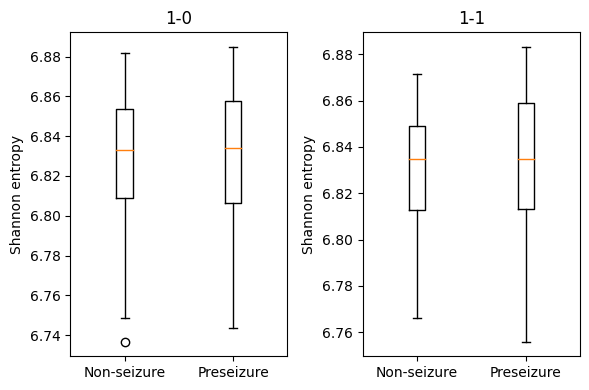

Subject 2


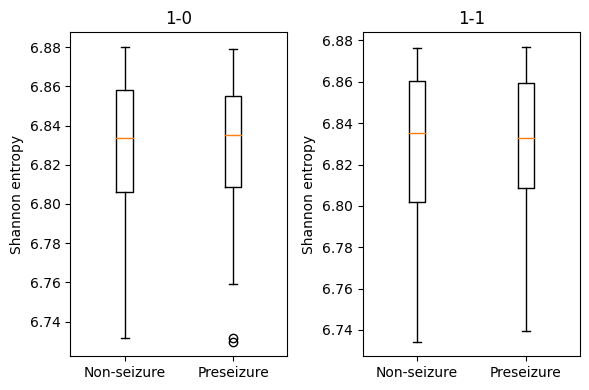

Subject 4


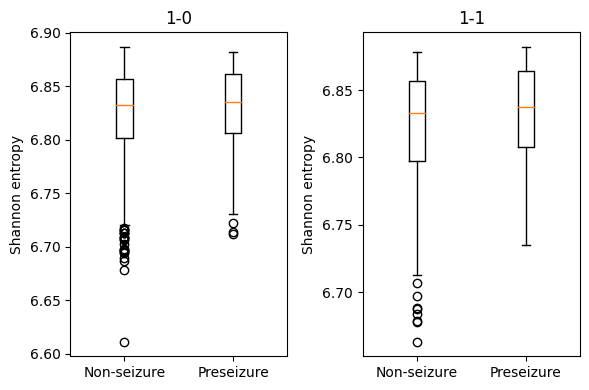

Subject 5


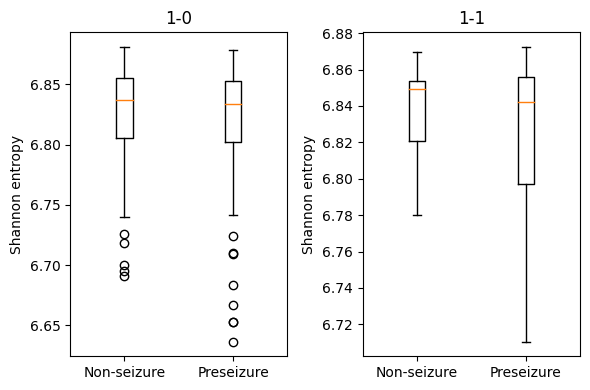

Subject 7


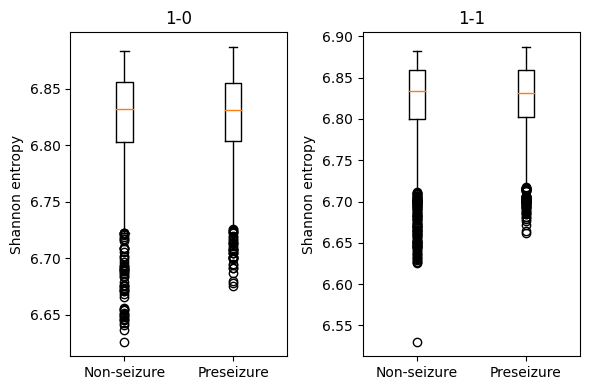

Subject 8


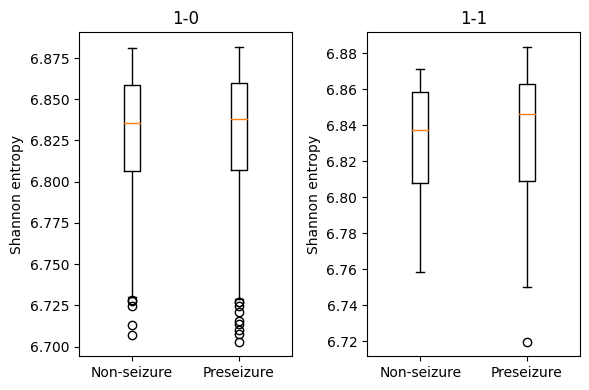

Subject 9


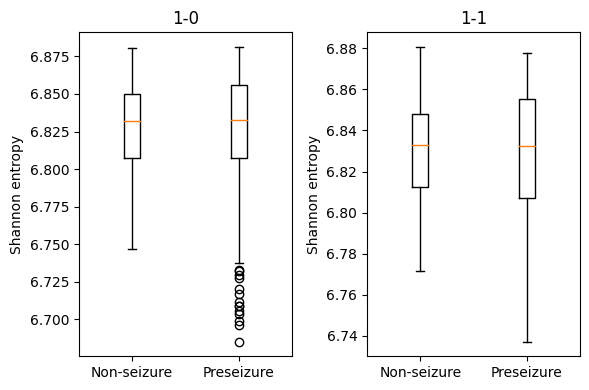

Subject 13


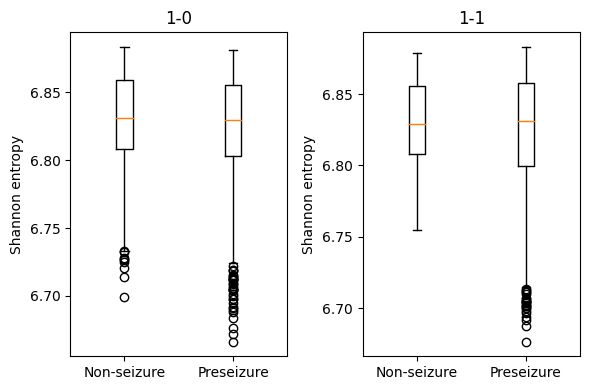

Subject 14


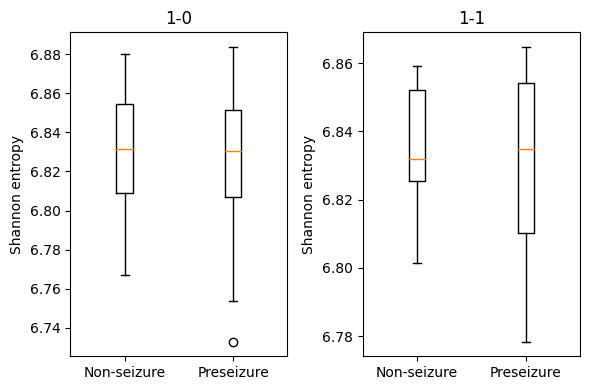

Subject 15


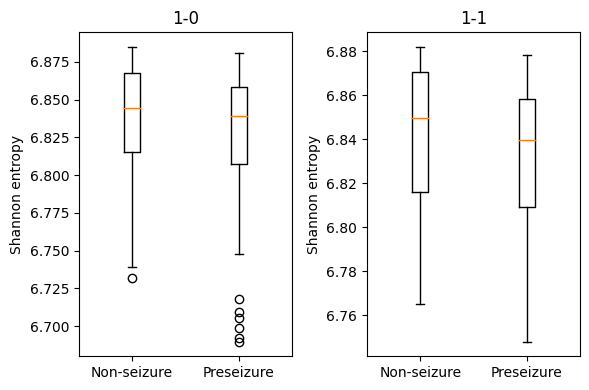

Subject 16


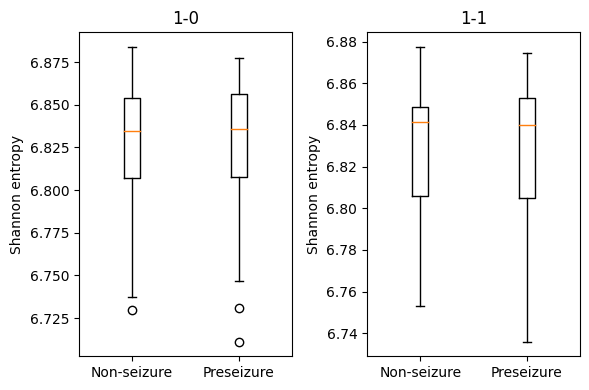

Subject 19


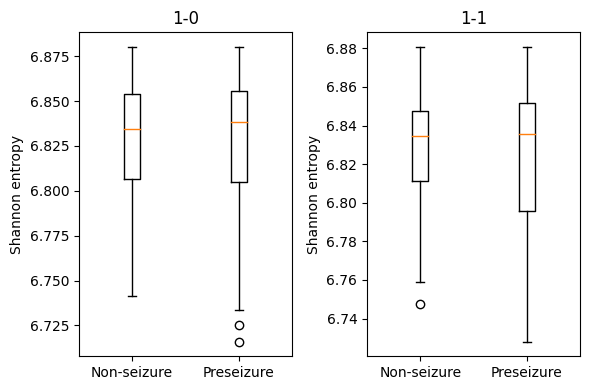

Subject 20


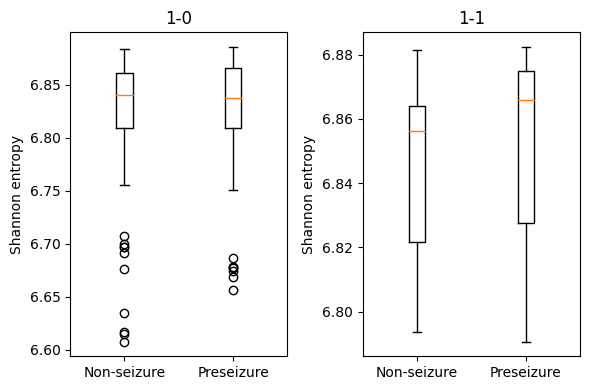

Subject 21


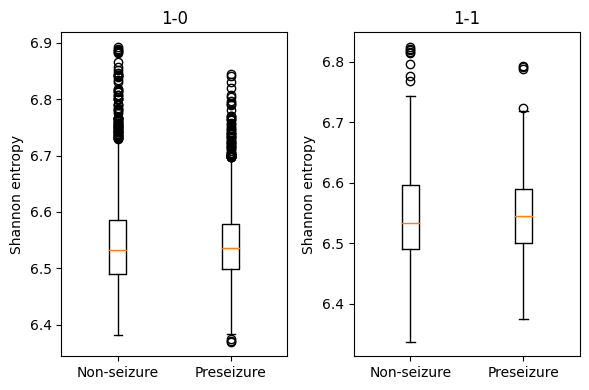

In [54]:
from itertools import combinations

main_folder = "/content/gdrive/My Drive/epigame-folder/30sec/"

cm_folder = main_folder + "connectivity_matrices/"

woi = "30sec"
measure = "PLI-(0,4)"

for sub in good_outcome_subjects:
    print(f"Subject {sub}")

    # Initializing lists for storing Shannon entropy for EN-EN (1-1) and EN-NN (1-0) connectivity
    conn_11_1, conn_10_1, conn_11_2, conn_10_2 = [],[],[],[]

    cm_filename = cm_folder + f"{sub}-{woi}-{measure}.prep"
    cm_load = REc.load(cm_filename)

    # EN(1) and NN(0) nodes
    nodes = NODES[str(sub)]
    node_ids = list(range(len(nodes)))
    resection_ids = [nodes.index(label) for label in RESECTION[sub]]
    non_resection_ids = list(np.setdiff1d(node_ids, resection_ids))

    # Iterate the upper triangular matrix without diagonal
    cms = cm_load.data.X
    rows = cms[0].shape[0]
    cols = cms[0].shape[1]

    n_epochs = int(len(cms)/2)

    # Sort epochs by index
    idx_cm_tuples = [(idx,cms[i]) for i,idx in enumerate(cm.i)]

    idx_cm_1 = dict(sorted({idx:cm for (idx,cm) in idx_cm_tuples[:n_epochs]}.items()))
    idx_cm_2 = dict(sorted({idx:cm for (idx,cm) in idx_cm_tuples[n_epochs::]}.items()))
    epochs_1 = list(idx_cm_1.values())
    epochs_2 = list(idx_cm_2.values())

    for node1 in range(rows):
        for node2 in range(node1 + 1, cols):  # Start from node1 + 1 to exclude the diagonal

            # List of connectivity measures for all epochs for node1-node2
            conn_1 = [get_connectivity(cm, node1, node2) for cm in epochs_1]
            conn_2 = [get_connectivity(cm, node1, node2) for cm in epochs_2]

            # Shannon entropy of the epochs
            entropy_1 = entropy(conn_1, base=2)
            entropy_2 = entropy(conn_2, base=2)

            if node1 in resection_ids or node2 in resection_ids:
              if node1 in resection_ids and node2 in resection_ids:
                conn_11_1.append(entropy_1)
                conn_11_2.append(entropy_2)
              else:
                conn_10_1.append(entropy_1)
                conn_10_2.append(entropy_2)

    # Create paired boxplots for 1-1 and 1-0 at non-seizure and preseizure
    fig, axs = plt.subplots(1, 2, figsize=(6,4))

    axs[0].boxplot([conn_10_1, conn_10_2], labels=['Non-seizure', 'Preseizure'])
    axs[0].set_title("1-0")
    axs[0].set_ylabel('Shannon entropy')

    axs[1].boxplot([conn_11_1, conn_11_2], labels=['Non-seizure', 'Preseizure'])
    axs[1].set_title("1-1")
    axs[1].set_ylabel('Shannon entropy')

    plt.tight_layout()
    plt.show()

Test Shannon entropy of the connectivity evolution, using random groups of EN and NN:

Subject 1
9 True


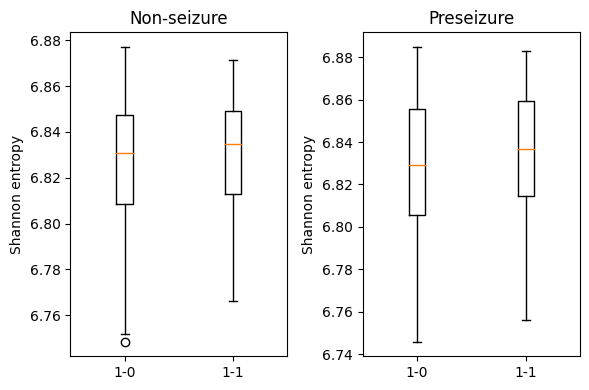

Subject 2
4 True


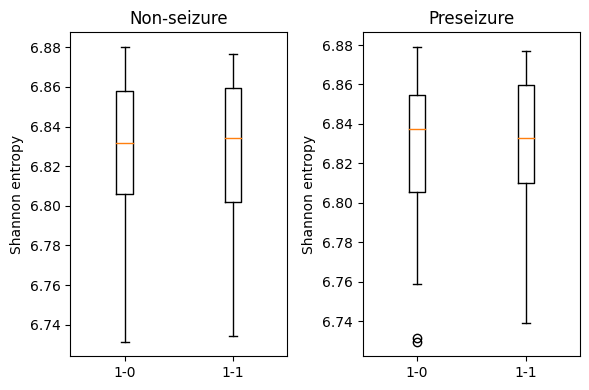

Subject 4
11 True


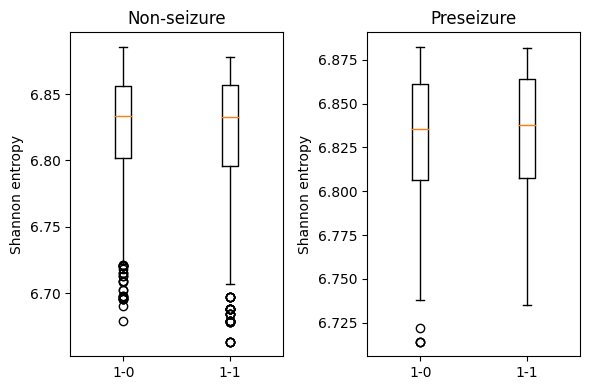

Subject 5
6 True


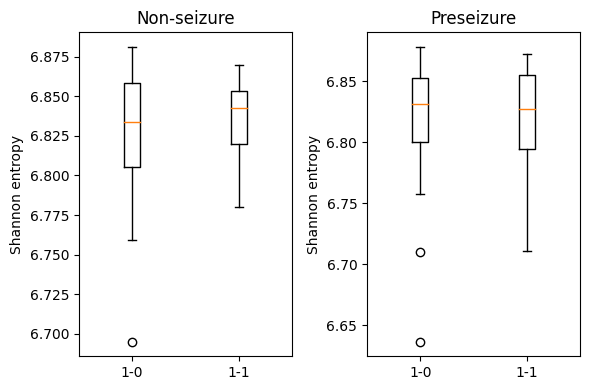

Subject 7
9 True


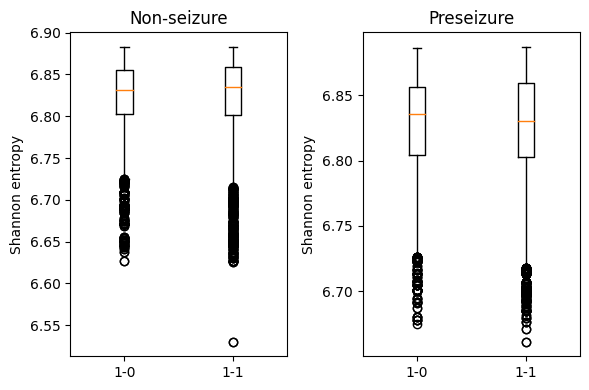

Subject 8
10 True


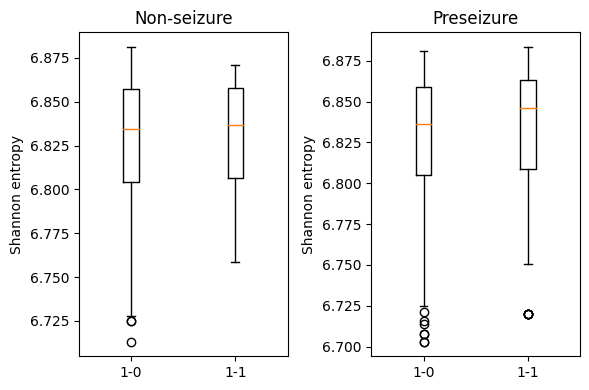

Subject 9
4 True


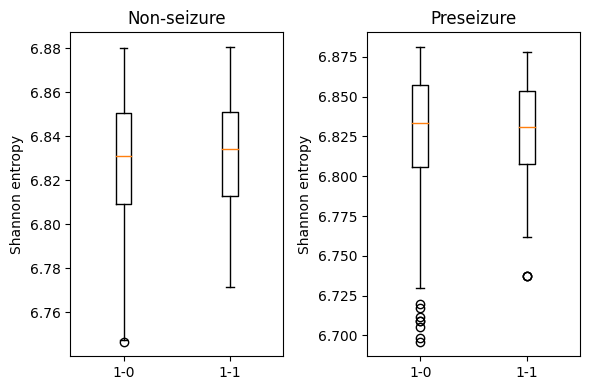

Subject 13
8 True


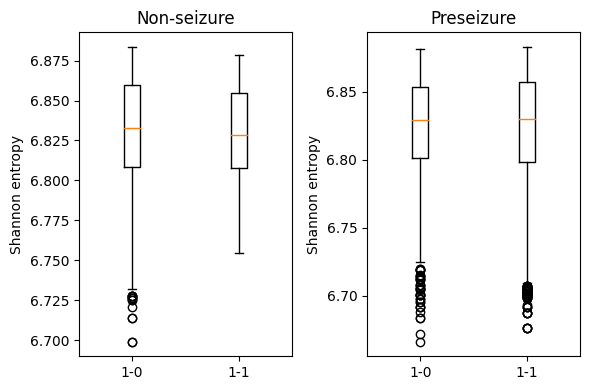

Subject 14
4 False


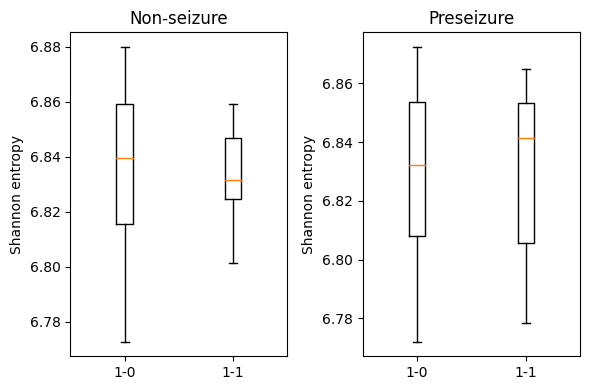

Subject 15
9 True


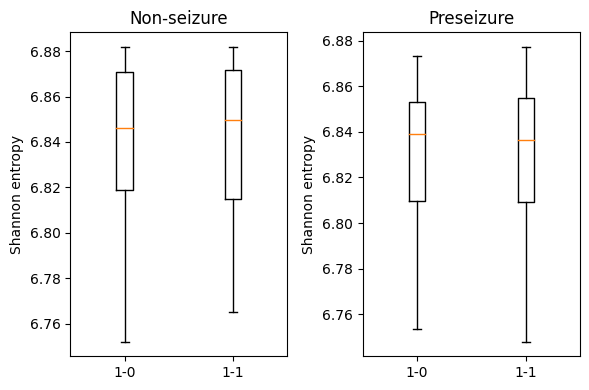

Subject 16
9 True


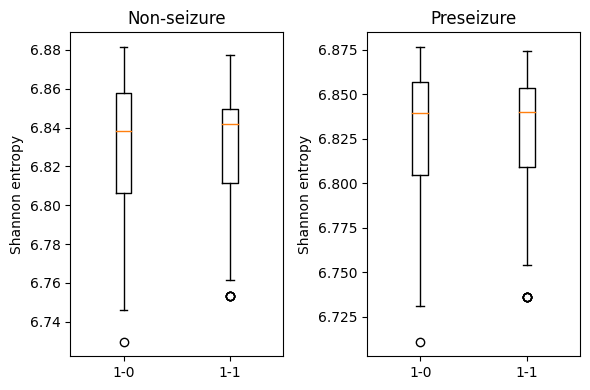

Subject 19
5 True


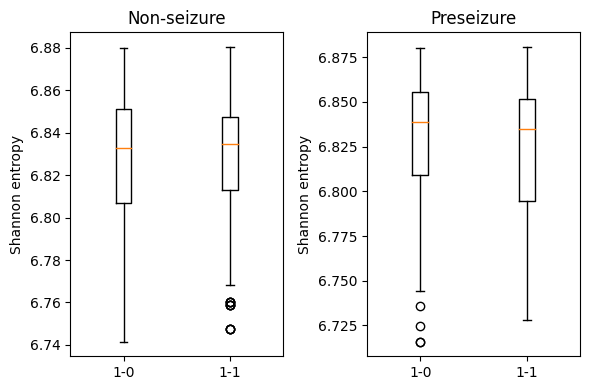

Subject 20
6 False


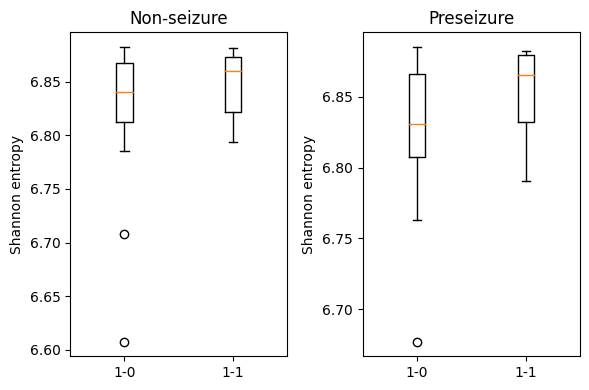

Subject 21
9 True


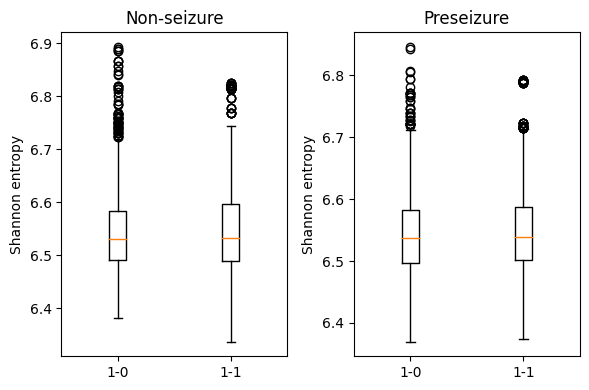

In [63]:
main_folder = "/content/gdrive/My Drive/epigame-folder/30sec/"

cm_folder = main_folder + "connectivity_matrices/"

woi = "30sec"
measure = "PLI-(0,4)"

for sub in good_outcome_subjects:
  print(f"Subject {sub}")

  # Initializing lists for storing Shannon entropy for EN-EN (1-1) and EN-NN (1-0) connectivity
  conn_11_1, conn_10_1, conn_11_2, conn_10_2 = [],[],[],[]

  cm_filename = cm_folder + f"{sub}-{woi}-{measure}.prep"
  cm_load = REc.load(cm_filename)

  # EN(1) and NN(0) nodes
  nodes = NODES[str(sub)]
  node_ids = list(range(len(nodes)))
  resection_ids = [nodes.index(label) for label in RESECTION[sub]]
  non_resection_ids = list(np.setdiff1d(node_ids, resection_ids))

  r = 0.1
  group_size = int(len(NODES[str(sub)])*r) if int(len(NODES[str(sub)])*r) < len(RESECTION[sub]) else len(RESECTION[sub])-1
  print(group_size, int(len(NODES[str(sub)])*r) < len(RESECTION[sub]))

  # Iterate the upper triangular matrix without diagonal
  cms = cm_load.data.X
  rows = cms[0].shape[0]
  cols = cms[0].shape[1]

  n_epochs = int(len(cms)/2)

  # Sort epochs by index
  idx_cm_tuples = [(idx,cms[i]) for i,idx in enumerate(cm.i)]

  idx_cm_1 = dict(sorted({idx:cm for (idx,cm) in idx_cm_tuples[:n_epochs]}.items()))
  idx_cm_2 = dict(sorted({idx:cm for (idx,cm) in idx_cm_tuples[n_epochs::]}.items()))
  epochs_1 = list(idx_cm_1.values())
  epochs_2 = list(idx_cm_2.values())

  for i in range(10):

    resection_group = list(np.random.choice(resection_ids, size=group_size, replace=False))
    non_resection_group = list(np.random.choice(non_resection_ids, size=group_size, replace=False))

    for en in resection_ids:
      if en not in resection_group:

        for node1 in range(rows):
            for node2 in range(node1 + 1, cols):  # Start from node1 + 1 to exclude the diagonal

              if node1==en or node2==en:

                # List of connectivity measures for all epochs for node1-node2
                conn_1 = [get_connectivity(cm, node1, node2) for cm in epochs_1]
                conn_2 = [get_connectivity(cm, node1, node2) for cm in epochs_2]

                # Shannon entropy of the epochs
                entropy_1 = entropy(conn_1, base=2)
                entropy_2 = entropy(conn_2, base=2)

                if node1 in resection_group or node2 in resection_group:
                  conn_11_1.append(entropy_1)
                  conn_11_2.append(entropy_2)
                elif node1 in non_resection_group or node2 in non_resection_group:
                  conn_10_1.append(entropy_1)
                  conn_10_2.append(entropy_2)

  # Create paired boxplots for 1-1 and 1-0 at non-seizure and preseizure
  fig, axs = plt.subplots(1, 2, figsize=(6,4))

  axs[0].boxplot([conn_10_1, conn_11_1], labels=['1-0', '1-1'])
  axs[0].set_title("Non-seizure")
  axs[0].set_ylabel('Shannon entropy')

  axs[1].boxplot([conn_10_2, conn_11_2], labels=['1-0', '1-1'])
  axs[1].set_title("Preseizure")
  axs[1].set_ylabel('Shannon entropy')

  plt.tight_layout()
  plt.show()

Test if connectivity evolution is a random walk:

In [65]:
from scipy.stats import norm

def variance_ratio_test(time_series, num_splits=2):
    n = len(time_series)
    k = n // num_splits

    split_series = np.array_split(time_series, num_splits)

    r_s = np.sum([(split_series[i][-1] - split_series[i][0]) ** 2 for i in range(num_splits)])
    s_s = np.sum([np.var(split_series[i]) for i in range(num_splits)])

    z = (r_s / (s_s * k)) - 1
    p_value = 1 - norm.cdf(z)

    return z, p_value

In [ ]:
main_folder = "/content/gdrive/My Drive/epigame-folder/30sec/"

cm_folder = main_folder + "connectivity_matrices/"

woi = "30sec"
measure = "PLI-(0,4)"

for sub in good_outcome_subjects:
  print(f"Subject {sub}")

  # Initializing lists for storing Shannon entropy for EN-EN (1-1) and EN-NN (1-0) connectivity
  conn_11_1, conn_10_1, conn_11_2, conn_10_2 = [],[],[],[]

  cm_filename = cm_folder + f"{sub}-{woi}-{measure}.prep"
  cm_load = REc.load(cm_filename)

  # EN(1) and NN(0) nodes
  nodes = NODES[str(sub)]
  node_ids = list(range(len(nodes)))
  resection_ids = [nodes.index(label) for label in RESECTION[sub]]
  non_resection_ids = list(np.setdiff1d(node_ids, resection_ids))

  r = 0.1
  group_size = int(len(NODES[str(sub)])*r) if int(len(NODES[str(sub)])*r) < len(RESECTION[sub]) else len(RESECTION[sub])-1
  print(group_size, int(len(NODES[str(sub)])*r) < len(RESECTION[sub]))

  # Iterate the upper triangular matrix without diagonal
  cms = cm_load.data.X
  rows = cms[0].shape[0]
  cols = cms[0].shape[1]

  n_epochs = int(len(cms)/2)

  # Sort epochs by index
  idx_cm_tuples = [(idx,cms[i]) for i,idx in enumerate(cm.i)]

  idx_cm_1 = dict(sorted({idx:cm for (idx,cm) in idx_cm_tuples[:n_epochs]}.items()))
  idx_cm_2 = dict(sorted({idx:cm for (idx,cm) in idx_cm_tuples[n_epochs::]}.items()))
  epochs_1 = list(idx_cm_1.values())
  epochs_2 = list(idx_cm_2.values())

  for i in range(10):

    resection_group = list(np.random.choice(resection_ids, size=group_size, replace=False))
    non_resection_group = list(np.random.choice(non_resection_ids, size=group_size, replace=False))

    for en in resection_ids:
      if en not in resection_group:

        for node1 in range(rows):
            for node2 in range(node1 + 1, cols):  # Start from node1 + 1 to exclude the diagonal

              if node1==en or node2==en:

                # List of connectivity measures for all epochs for node1-node2
                conn_1 = [get_connectivity(cm, node1, node2) for cm in epochs_1]
                conn_2 = [get_connectivity(cm, node1, node2) for cm in epochs_2]

                # Check random walk of the epochs
                z_score_1, p_value_1 = variance_ratio_test(conn_1)
                z_score_2, p_value_2 = variance_ratio_test(conn_2)

                if node1 in resection_group or node2 in resection_group:
                  conn_11_1.append(p_value_1)
                  conn_11_2.append(p_value_2)
                elif node1 in non_resection_group or node2 in non_resection_group:
                  conn_10_1.append(p_value_1)
                  conn_10_2.append(p_value_2)

  # Create paired boxplots for 1-1 and 1-0 at non-seizure and preseizure
  fig, axs = plt.subplots(1, 2, figsize=(6,4))

  axs[0].boxplot([conn_10_1, conn_11_1], labels=['1-0', '1-1'])
  axs[0].set_title("Non-seizure")
  axs[0].set_ylabel('Random walk test P-value')

  axs[1].boxplot([conn_10_2, conn_11_2], labels=['1-0', '1-1'])
  axs[1].set_title("Preseizure")
  axs[1].set_ylabel('Random walk test P-value')

  plt.tight_layout()
  plt.show()